# Alpha Research

The goal in this project is to define a liquid universe of stocks where we would apply our factors into it to see through our factor analysis if there is a potential or not to send these results to production. After selecting and combining factors using Machine Learning technics, the combined factor is analyzed and improved with an optimizer function to integrate our risk model.  

This project workflow is comprised of distinct stages including: 

1. Parameters
2. Universe definition
3. Sector definition
4. Alpha factors
5. Factor analysis
6. Factors combination
7. Risk analysis for equal weights
8. Integrating factor data to the optimizer
9. Optimized factor analysis
10. Predicted portfolio

In this context we have used different source of data provided from 
[Sharadar](https://www.quandl.com/publishers/sharadar) and 
[IFT](https://www.quandl.com/publishers/ift) as described below:

- Sharadar Equity Prices ([SHARADAR/SEP](https://www.quandl.com/databases/SEP/data))
Updated daily,End-Of-Day (EOD) price (ohlcv) data for more than 14,000 US public companies.  
- Indicator Descriptions ([SHARADAR/INDICATORS](https://www.quandl.com/databases/SF1/data))
Description of indicators listed in SF1 table for more than 14,000 US public companies.
- Tickers and Metadata ([SHARADAR/TICKERS](https://www.quandl.com/databases/SF1/data))
Information and metadata for more than 14,000 US public companies.
- Core US Fundamentals ([SHARADAR/SF1](https://www.quandl.com/databases/SF1/data))
 150 essential fundamental indicators and financial ratios, for more than 14,000 US public companies.
- Daily Metrics ([SHARADAR/DAILY](https://www.quandl.com/databases/SF1/data))
 5 essential metrics indicators and financial ratios daily updated, for more than 14,000 US public companies.
- Sentiment Analysis and News Analytics ([IFT/NSA](https://www.quandl.com/databases/NS1/data)) 
News, blogs, social media and proprietary sources for thousands of stocks.

In [2]:
import pyfolio as pf

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import zipfile
import os
import alphalens as al
import quandl
import quantstats as qs
import matplotlib.pyplot as plt
import datetime as datetime
import numpy as np
import pandas as pd
import talib
import seaborn as sns
from time import time
from sklearn import preprocessing
import pytz
import itertools
import warnings
from time import sleep

warnings.filterwarnings("ignore")

In [4]:
import risk_model
import factorize
import account
import utils_s
import feature_weights

In [5]:
secret_key = pd.read_csv('secret_key.txt',header=None)
quandl.ApiConfig.api_key = secret_key[0][0]

# 1 - Parameters

Before diving into factor research and quantitative analysis, we have to define parameters that will be used in different stages of this project. The purpose is to try different parameters to optimize our output portfolio during the time. The first parameter we set here below is `update_data` that is used to decide if we want to update the data or not.

In [6]:
update_data = True
if update_data:
    print ('ready to update data')
else:
    print ('data is already updated') 

ready to update data


## 1 - 1 - Time series data parameters

In this part, we set date parameters which are used for calling data from Quandl API. In this context, we call SEP/SHARADAR, DAILY/SHARADAR, and IFT/NSA for three years of data and SF1/SHARADAR for four years. The reason for this slicing is related to our final factor data where we look back one year. For example, some factors window length is set to one year, which means we need to load a minimum of three years data to chunk the final data frame in one year slice.

In [7]:
tod = datetime.datetime.today().date()
print ('current date: {}'.format(tod))

current date: 2020-07-19


In [8]:
# SF1
some_years = str(tod.year - 4)
month = str(tod.month)
day = str(tod.day)
start_f = '{}-{}-{}'.format(some_years,month,day)
print ('SF1 data starting date: {}'.format(start_f))

SF1 data starting date: 2016-7-19


In [9]:
# SEP & daily
two_years = str(tod.year - 3)
month = str(tod.month)
day = str(tod.day)
start_sep = '{}-{}-{}'.format(two_years,month,day)
print ('SEP,Daily and Sentiment data starting date: {}'.format(start_sep))

SEP,Daily and Sentiment data starting date: 2017-7-19


## 1 - 2 - Factor data period parameters

We set our final date parameter to one year factor data. The reason is that we believe more than one-year factor analysis will decrease our efficiency in prediction and could affect our interpretation of results.

In [10]:
# Slicing data for 1y
years_to_slice = 1
year = str(tod.year - years_to_slice)
month = str(tod.month)
day = str(tod.day)
ayear = '{}-{}-{}'.format(year,month,day)

start = ayear
end = str(tod)
print ('Final slicing date for {} year: {}'.format(years_to_slice,ayear))

Final slicing date for 1 year: 2019-7-19


## 1 - 3 - Universe parameters

The universe definition is an important step in this project. These parameters set here below will impact our analysis and need to be tuned as well as other parameters. metadata parameters are composed of `cap_select`, `exchange_select`, `currency_select` and `delisted_select` which are used to define our fisrt universe of stocks. For the second universe, `filteration_number` represents the number of liquid securities selected by dollar volume function and `smoothing_universe_period` represents the moving average window length in dollar volume function to select liquid securities smoothed over time. The following parameters are selected from the following values:

#### Market Cap:

- 1 - Nano
- 2 - Micro 
- 3 - Small 
- 4 - Mid 
- 5 - Large 
- 6 - Mega

#### Exhcange:

- NASDAQ 
- NYSE
- BATS
- NYSEARCA
- NYSEMKT
- OTC

#### Currency:

USD, EUR, ARS, AUD, BRL, CAD, CHF, CLP, 
CNY, COP, DKK, GBP, HKD, IDR, ILS, INR, 
JPY, KRW, MXN, MYR, NOK, NZD, PEN,PHP, 
PLN, RUB, SEK, TRY, TWD, ZAR

#### Delisted:

'Y' or 'N'

In [11]:
# metadata parameters
cap_select = ['6 - Mega', '5 - Large', '4 - Mid']
exchange_select = ['NYSE', 'NASDAQ']
currency_select = ['USD']
delisted_select = ['N']

In [ ]:
# dollar volume parameters
filteration_number  = 800
smoothing_universe_period = 100

## 1 - 4 - Pipeline parameters

Creating factor data in a different way to obtain significant results is a critical subject treated in this project. The goal is to tune up the factor parameter to get optimal results. This section lets us test different parameters for these factors and navigates over different factor data. `smoothed_value` is the window length moving average parameter used to remove the noise created by factor variation. We will discuss other parameters in the factors section. 

In [12]:
smoothed_value = 5

In [13]:
fundamental_ind = ['cashneq']
momentum_in = {'momentum_252d':252}
sma_in = {'sma200':200}
daily_in = {'marketcap':100, 'evebitda':100}
over_in = {'overnight_sentiment_5d':5}
direction_in = {'direction_100d':100}
sent_in = {'sentiment_100d':100}

## 1 - 5 - Factor analysis parameters

Here below we select periods to analyze our multi-factor output. These periods are selected according to our trading strategy and portfolio management methods. The `rebalance_period` is also an important parameter to choose carefully and consider commission fees in our portfolio management system. 

We use [Principal Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) in our risk management model to reduce the dimensionality of the risk factors. `factor exposures` parameter is the dimension that we want to reduce to it.

In [14]:
combined_periods = (3,5,10)
rebalance_period = 5

In [15]:
# Risk analysis
factor_exposures = 13

## 1 - 6 - Optimizer parameters

After combining factors we put it into the optimizer function which will maximize alpha factor and consider our risk model in counterpart. `risk_cap` is used to set the risk exposure parameter. More the risk is and more the alpha will be. `lambda_reg` is used regularized our optimized function. it is operating like a portfolio enhancer.

In [16]:
risk_cap = 0.05
lambda_reg = 0.5

## 1 - 7 - Sector parameters

Our factor data is preprocessed and grouped by sector. Here below we can select sectors to drop, `sec_to_drop` regrouped sectors to not appear in factor data and our analysis to avoid sectors which have poor results. We also have the choice to drop specific sectors from long universe or short universe. For example the Tehnology sector shows good results in long qunatile and poor results in short quantile, it would be interesting to add this sector to `drop_short_sec`. The following parameter is selected from the following values:

#### Sectors:

- Basic Materials
- Communication Services
- Consumer Cyclical
- Consumer Defensive
- Energy
- Financial Services
- Healthcare
- Industrials
- Real Estate
- Technology
- Utilities
- None

In [17]:
sec_to_drop = [ 
                'Basic Materials',
                'Industrials',
                'Healthcare',
                'Financial Services',
                'Communication Services',
                'Real Estate',
                'Energy',
                'Utilities'
              ]

In [18]:
drop_long_sec = []
drop_short_sec = []

In [19]:
assert set(sec_to_drop) & set(drop_long_sec) == set()
assert set(sec_to_drop) & set(drop_short_sec) == set()
assert set(drop_long_sec) & set(drop_short_sec) == set()

## 1 - 9 - Quantiles

Here after the quantiles parameters are defining the equal portions of datas to be analyzed and considered for the future portfolio. `quantile_portions` is the number of qunatiles we want to analyze and work with. In the other hand `quantile_to_analysis` is the quantiles selected for the final analyze and portfolio. We use to select extremety quantiles to get the best results. 

In [20]:
qunatile_portions = 25
quantile_to_analyse = [1,qunatile_portions]

## 1 - 10 - Long/Short leverage 

The leverage we choose for our long/short portfolio could vary during time and market conditions. Parameters below let us choose the leverage with consideration of the total leverage which is equal to one.

In [21]:
percent_long_leverage_target = 0.6
percent_short_leverage_target = 0.4

In [22]:
assert percent_long_leverage_target + percent_short_leverage_target == 1

# 2 - Universe definition

In this project, the universe is defined as a group of assets having high liquidy over a period. This universe will be used to compare systematic factors. Before proceeding to the selection of stocks we use `get_table` from Quandl API to load metadata of all stocks.

In the next step, we use our universe parameters to select the fisrt universe of stocks. The criteria for this selection are as followed:

- Exchange
- Market cap
- Currency
- Delisted

The following codes are used to define the first universe described above.

## 2 - 1 - Metadata

In [23]:
meta = quandl.get_table('SHARADAR/TICKERS', table='SF1',paginate=True)
meta.set_index('ticker',inplace=True, drop=True)

In [162]:
set(meta['sector'])

{'Basic Materials',
 'Communication Services',
 'Consumer Cyclical',
 'Consumer Defensive',
 'Energy',
 'Financial Services',
 'Healthcare',
 'Industrials',
 None,
 'Real Estate',
 'Technology',
 'Utilities'}

## 2 - 1 - 1 - First universe

In [159]:
try:
    exchange = []
    for i in exchange_select:
        exchange.append(list(meta[(meta['exchange'] == i)].index))
    meta_ex = meta.loc[list(itertools.chain.from_iterable(exchange))]
except:
    meta_ex = meta

try:
    currency = []
    for i in currency_select:
        currency.append(list(meta_ex[(meta_ex['currency'] == i)].index))
    meta_ex_cu = meta_ex.loc[list(itertools.chain.from_iterable(currency))]
except:
    meta_ex_cu = meta_ex

try:
    delisted = []
    for i in delisted_select:
        delisted.append(list(meta_ex_cu[(meta_ex_cu['isdelisted'] == i)].index))
    meta_ex_cu_de = meta_ex_cu.loc[list(itertools.chain.from_iterable(delisted))]
except:
    meta_ex_cu_de = meta_ex_cu
    
try:    
    cap = []
    for i in cap_select:
        cap.append(list(meta_ex_cu_de[(meta_ex_cu_de['scalemarketcap'] == i)].index))
    meta_ex_cu_de_cap = meta_ex_cu_de.loc[list(itertools.chain.from_iterable(cap))]
except:
    meta_ex_cu_de_cap = meta_ex_cu_de

In [160]:
u1 = list(meta_ex_cu_de_cap.index)

In [161]:
print ('{} companies selected in first selection'.format(len(u1)))

0 companies selected in first selection


## 2 - 2 - OHLCV data

Once the first universe `first_universe` is defined, we use it to get SHARADAR/SEP data and store this table as a zip file on the local drive. This table gives us the ohlcv data started at `start_sep` defined in the parameters section and ended at the current date `tod`. The zip file is extracted, sorted into a multi-index data frame, and finally cleaned using our local function `cleaning_dataframe` imported from `utils_s.py`.

In [27]:
if update_data:
    quandl.export_table('SHARADAR/SEP',
                        ticker=u1, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename = 'data/ohlcv.zip')

We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
data/ohlcv.zip


In [28]:
with zipfile.ZipFile('data/ohlcv.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SEP':
        
        ohlcv = pd.read_csv(item)
        ohlcv['date'] = pd.to_datetime(ohlcv['date'])
        ohlcv = ohlcv.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        ohlcv.drop(['lastupdated','dividends','closeunadj'],axis=1,inplace=True)

        os.remove(item)

cleaning data
columns are clean


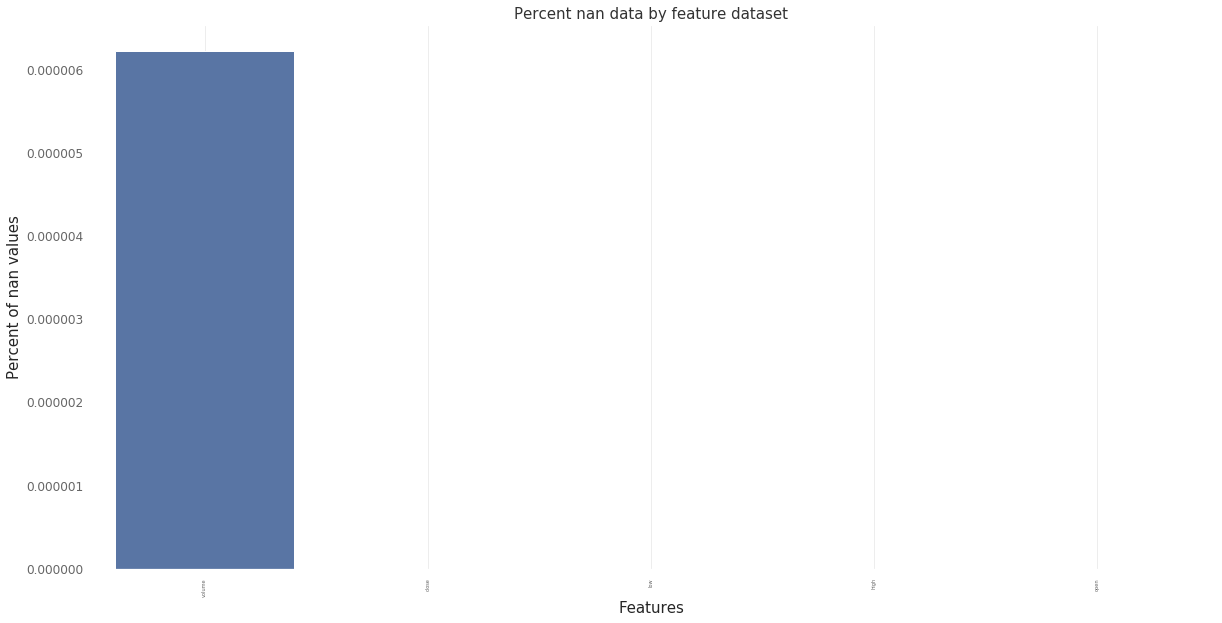

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [29]:
ohlcv = utils_s.cleaning_dataframe(ohlcv,0.2)

## 2 - 2 - 1 - Second universe

In this section, the `dollar_volume_universe` attends to select liquid stocks with significant market cap. In this context, the close frame is multiplied to volume to obtain the market cap data frame. Then we sort assets having the highest market cap. the number of assets selected is set in the parameters section through `filteration_number` and smoothed over time with `smoothing_universe_period`.

In [30]:
def dollar_volume_universe(tickers_num, ohlcv, sma_period):
    
    ohlcv['dollar_volume'] = ohlcv['close']*ohlcv['volume']
    dollar_vol = ohlcv['dollar_volume'].unstack('ticker')
    sma = pd.DataFrame(index = dollar_vol.index)
    try:
        for tick in dollar_vol.columns:
            sma[tick] = talib.SMA(dollar_vol[tick].values, timeperiod=sma_period)
    except:
        pass
    
    last = sma.iloc[-1,:]
    dol = pd.DataFrame(data = last.values,index = last.index, columns = ['dv'])
    dol.dropna(inplace = True)
    
    return list(dol.sort_values(by='dv', ascending=False).iloc[:tickers_num].index)    

In [31]:
universe = dollar_volume_universe(tickers_num = filteration_number, ohlcv = ohlcv, sma_period = smoothing_universe_period)

In [32]:
print ('{} companies selected out of {} for second selection'.format(len(universe),len(u1)))

800 companies selected out of 1982 for second filteration


In [146]:
assert len(universe) == filteration_number

AssertionError: 

## 2 - 2 - 2 - Third universe

A sector selection model is a systematic tool that tilts a portfolio towards sectors that are predicted to outperform and underweights those that are predicted to underperform. If the process can effectively discern winning/losing industry groups, it can enhance the value added from a stock-selection methodology. Here below we use `sec_to_drop` which is composed of sectors to not include in the final assets (third universe). the output of this function will be the final selection.

In [33]:
universe_sectors = pd.DataFrame(index=universe, columns=['sectors'])
for i in universe:
    universe_sectors.loc[i] = meta_ex_sc_cu.loc[i]['sector']
    
    for sec in sec_to_drop:
        if meta_ex_sc_cu.loc[i]['sector'] == sec:
            universe_sectors.drop(i, axis=0,inplace=True)

In [34]:
universe = list(universe_sectors.index)

In [35]:
print ('{} companies selected after sector cleaning out of {} for second filteration'.format(len(universe),len(u1)))

334 companies selected after sector drop out of 1982 for second filteration


## 2 - 3 - Fundamental data

After defining the final `universe`, we get fundamental SHARADAR/SF1 data and store this table as a zip file on the local drive. This table gives us the fundamental data of Most Recent Quarter (MRQ) Reported started at `start_f` defined in the parameters section and ended at the current date `tod`. The zip file is extracted, sorted into a multi-index data frame, and finally cleaned using our local function `cleaning_dataframe` imported from `utils_s.py`.

In [36]:
if update_data:
    #qopts={"columns":ind}
    quandl.export_table('SHARADAR/SF1',
                        ticker=universe, 
                        dimension = 'MRQ', 
                        calendardate={'gte':start_f,'lte':str(tod)}, 
                        filename='data/fundamental.zip')

We are generating the zip file now, please wait...
data/fundamental.zip


In [37]:
with zipfile.ZipFile('data/fundamental.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SF1':
        sf1 = pd.read_csv(item)
        sf1 = sf1.set_index(['calendardate', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        sf1.drop(['datekey','reportperiod','lastupdated','dimension'],axis=1,inplace=True)
        os.remove(item)  

cleaning data
columns are clean


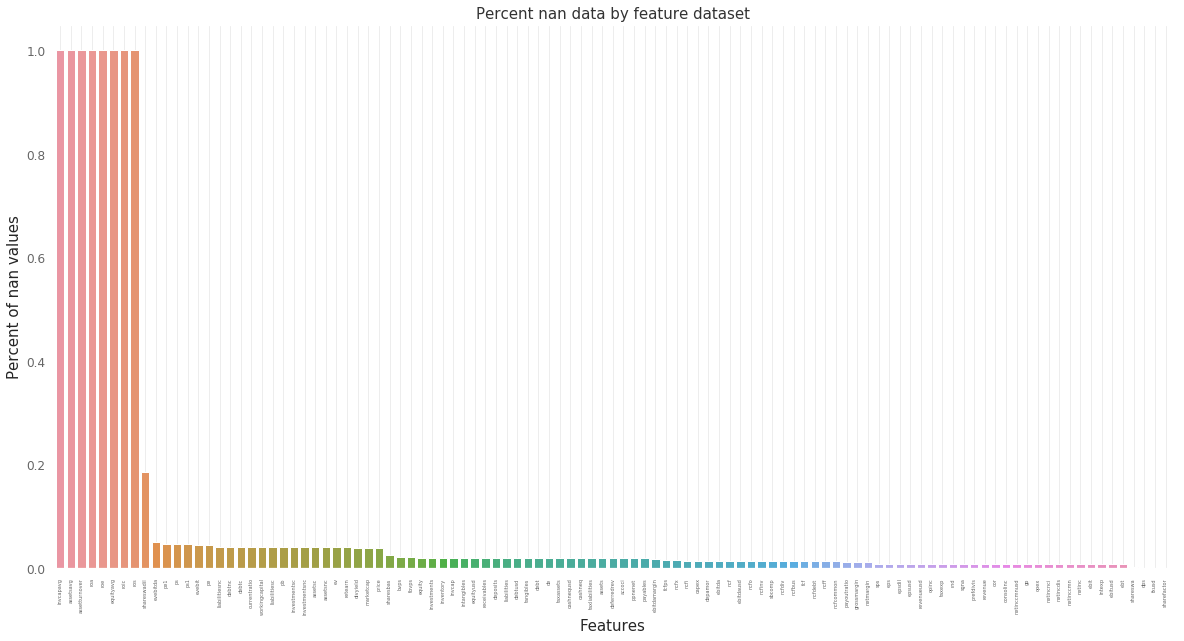

The percentage of dropped columns is 7%.
Dropped 8 columns out of 105


In [39]:
sf1 = utils_s.cleaning_dataframe(sf1,0.2)

In [40]:
sf1['roe'] = sf1['netinc'] / sf1['equity']
sf1['roa'] = sf1['netinc'] / sf1['assets']
sf1['fcf_yield'] = sf1['fcf'] / sf1['ev']

## 2 - 4 - Daily metrics data

We continue to download data, here get daily metrics SHARADAR/DAILY data and store this table as a zip file on the local drive. This table gives us the data that with discussed in previously started at `start_sep` defined in the parameters section and ended at the current date `tod`. The zip file is extracted, sorted into a multi-index data frame, and finally cleaned using our local function `cleaning_dataframe` imported from `utils_s.py`.

In [41]:
if update_data:
    quandl.export_table('SHARADAR/DAILY',
                        ticker=universe, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename='data/daily.zip')

We are generating the zip file now, please wait...
data/daily.zip


In [42]:
with zipfile.ZipFile('data/daily.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'DAILY':
        daily = pd.read_csv(item)
        daily['date'] = pd.to_datetime(daily['date'])
        daily = daily.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        daily.drop(['lastupdated'],axis=1,inplace=True)
        os.remove(item) 

cleaning data
columns are clean


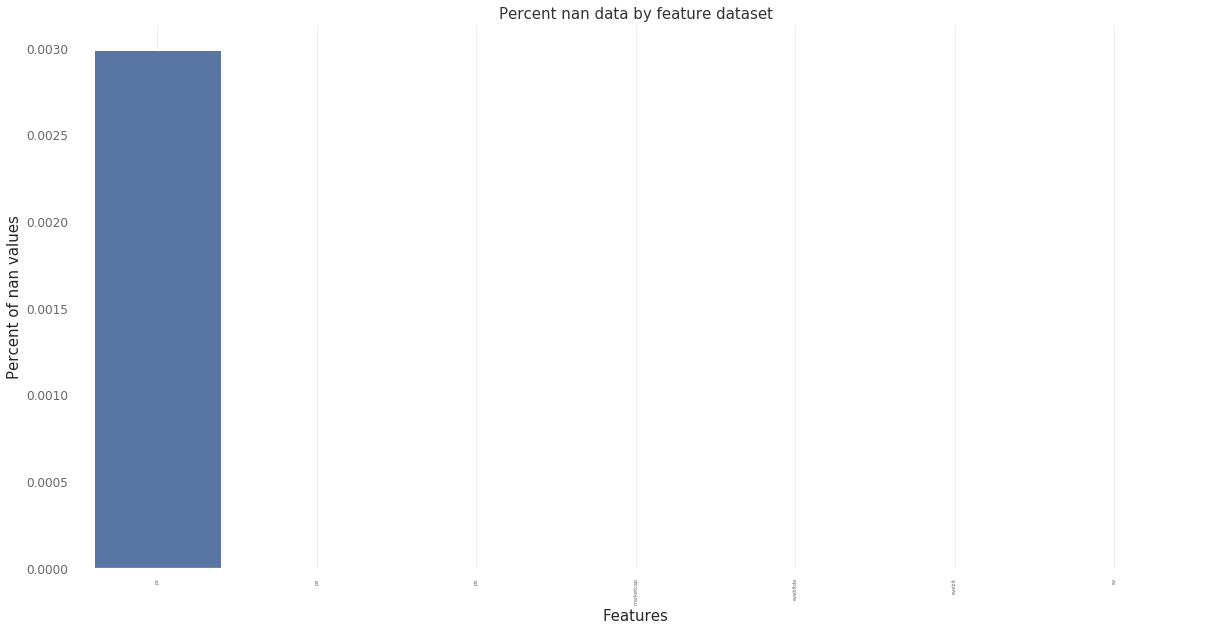

The percentage of dropped columns is 0%.
Dropped 0 columns out of 7


In [43]:
daily = utils_s.cleaning_dataframe(daily,0.2)

## 2 - 5 - Sentiment data

The last data we get is sentiment data IFT/NSA data and store this table as a zip file on the local drive. This table gives us the data that discussed previously started at `start_sep` defined in the parameters section and ended at the current date `tod`. The zip file is extracted, sorted into a multi-index data frame, and finally cleaned using our local function `cleaning_dataframe` imported from `utils_s.py`.

In [44]:
if update_data:
    quandl.ApiConfig.api_key = 'WW4cUYaXdyxgjvdu4z9s'
    quandl.export_table('IFT/NSA',
                        ticker=universe, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename='data/sent.zip')

We are generating the zip file now, please wait...
data/sent.zip


In [45]:
with zipfile.ZipFile('data/sent.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'IFT' and item.split('_')[1] == 'NSA':
        sent = pd.read_csv(item)
        sent['date'] = pd.to_datetime(sent['date'])
        sent = sent.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        sent = sent[sent['exchange_cd']=='US']
        sent.drop(['name','exchange_cd'],axis=1,inplace=True)
        os.remove(item) 

cleaning data
columns are clean


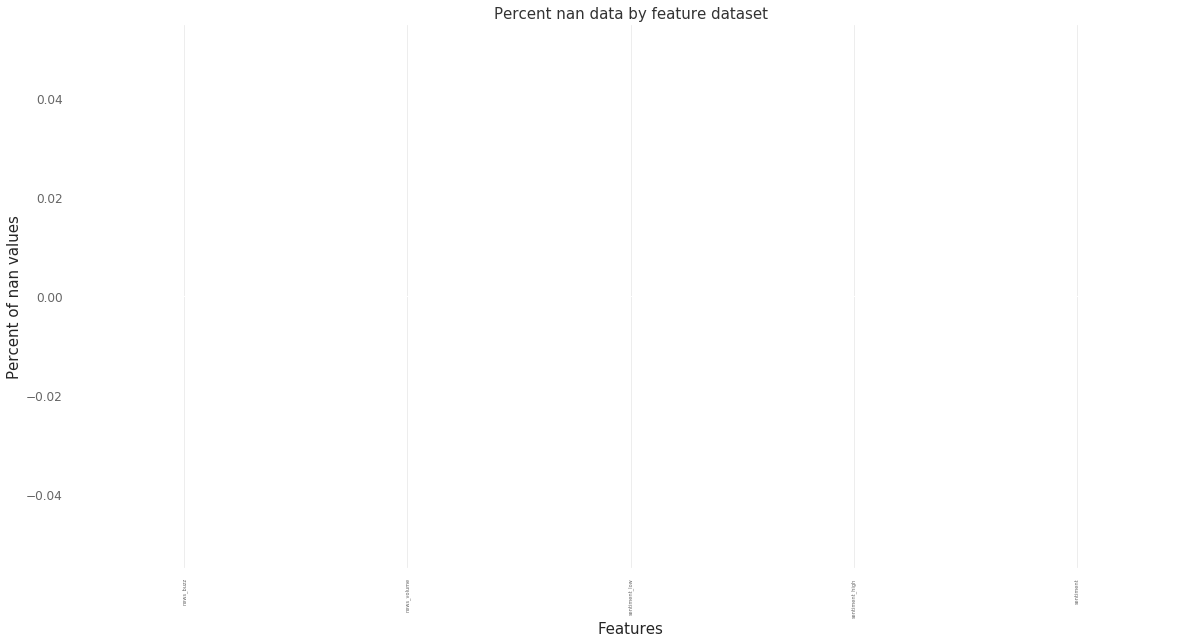

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [46]:
sent = utils_s.cleaning_dataframe(sent,0.2)

# 3 - Universe intersection

All the data is collected and stacked separately into a multi-index data frame. However, some of the assets defined previously in the universe section are dropped or not collected during the download and cleaning process. Therefore, the goal in this section is to get the intersection of assets represented for each data frame (`sent`,`sf1`,`daily` and `ohlcv`).

In [47]:
new_universe =list(set(sent['sentiment'].unstack('ticker').columns) & set(sf1.index.levels[1]) & set(daily.index.levels[1]) & set(ohlcv.index.levels[1]))

In [165]:
print ('{} assets dropped after intersectioning'.format((len(universe) - len(new_universe))))

31 asset dropped after intersectioning


## 3 - 1- Sectors

In [167]:
meta_cleaned = meta_ex_sc_cu.loc[new_universe,:]
print ('Sectors in cleaned data: \n')
sectors = {}
for i in set(meta_cleaned['sector']):
    print (' ',i)
    sectors[i] = list(meta_cleaned[meta_cleaned['sector'] == i].index)

Sectors in cleaned data: 

  Consumer Cyclical
  Technology
  Consumer Defensive


# 4 - Alpha factors

## 4 - 1 - Factorizing

In [51]:
close = ohlcv['close'].unstack('ticker')[new_universe]
openn = ohlcv['open'].unstack('ticker')[new_universe]
high = ohlcv['high'].unstack('ticker')[new_universe]
low = ohlcv['low'].unstack('ticker')[new_universe]

In [52]:
pricing = openn.loc[slice(start,end),:].tz_localize('UTC')[new_universe]

In [53]:
# daily

daily_data = {}

for i in daily_in.keys():
    
    df_daily = daily[i].unstack('ticker')
    reversion = factorize.Momentum(df_daily,daily_in[i])*-1
    smoothed_reversion = factorize.Smooth(reversion,smoothed_value)
    smoothed_reversion_scaled = pd.DataFrame(data = preprocessing.scale(smoothed_reversion),
                                                     index = smoothed_reversion.index,
                                                     columns = smoothed_reversion.columns)
    smoothed_reversion_scaled.index = pd.to_datetime(smoothed_reversion_scaled.index)
    smoothed_reversion_scaled = smoothed_reversion_scaled.loc[slice(start,end),:]

    result = []
    for sec in sectors.keys():
        result.append(smoothed_reversion_scaled[sectors[sec]].sub(smoothed_reversion_scaled[sectors[sec]].mean(axis=1),axis=0))

    smoothed_reversion_neutralized_scaled = pd.concat(result,axis=1)
    
    daily_data[i] = smoothed_reversion_neutralized_scaled


In [54]:
# SMA
sma_data = {}

for name,period in sma_in.items():

    df= pd.DataFrame(index = close.index)

    try:
        for tick in close.columns:
            df[tick] = talib.SMA(close[tick].values, timeperiod=period)
    except:
        pass

    sma_min = (close - df)*-1
    smoothed_sma_min = factorize.Smooth(sma_min,smoothed_value)
    smoothed_sma_min.index = pd.to_datetime(smoothed_sma_min.index)
    smoothed_sma_min = smoothed_sma_min.loc[slice(start,end),:]
    
    # Neutralizing by sector
    result = []
    for sec in sectors.keys():
        result.append(smoothed_sma_min[sectors[sec]].sub(smoothed_sma_min[sectors[sec]].mean(axis=1),axis=0))

    smoothed_sma_min_neutralized = pd.concat(result,axis=1)    
    
    smoothed_sma_min_neutralized_scaled = pd.DataFrame(data = preprocessing.scale(smoothed_sma_min_neutralized),
                                                              index = smoothed_sma_min_neutralized.index,
                                                              columns = smoothed_sma_min_neutralized.columns)
    
    sma_data[name] = smoothed_sma_min_neutralized_scaled
    

In [55]:
over_data = {}

for name,period in over_in.items():
    overnight_sentiment = factorize.overnight_sentiment(close, openn, 1, trailing_window=period)
    smoothed_overnight_sentiment = factorize.Smooth(overnight_sentiment,smoothed_value)
    
    smoothed_overnight_sentiment.index = pd.to_datetime(smoothed_overnight_sentiment.index)
    
    smoothed_overnight_sentiment = smoothed_overnight_sentiment.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_overnight_sentiment[sectors[sec]].sub(smoothed_overnight_sentiment[sectors[sec]].mean(axis=1),axis=0))

    smoothed_overnight_sentiment_neutralized_scaled = pd.concat(result,axis=1)
    
    over_data[name] = smoothed_overnight_sentiment_neutralized_scaled
    

In [56]:
# mean reversion
momentum_data = {}

for name,period in momentum_in.items():
    
    mean_reversion = factorize.Momentum(close,period)*-1
    smoothed_mean_reversion = factorize.Smooth(mean_reversion,smoothed_value)
    
    smoothed_mean_reversion.index = pd.to_datetime(smoothed_mean_reversion.index)
    smoothed_mean_reversion = smoothed_mean_reversion.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_mean_reversion[sectors[sec]].sub(smoothed_mean_reversion[sectors[sec]].mean(axis=1),axis=0))

    smoothed_mean_reversion_neutralized_scaled = pd.concat(result,axis=1)
  
    momentum_data[name] = smoothed_mean_reversion_neutralized_scaled


In [57]:
# direction
direction_data = {}

for name,period in direction_in.items():
    
    direct = factorize.direction(close, openn, 1, period)
    smoothed_direct = factorize.Smooth(direct,smoothed_value)

    smoothed_direct.index = pd.to_datetime(smoothed_direct.index)
    smoothed_direct = smoothed_direct.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_direct[sectors[sec]].sub(smoothed_direct[sectors[sec]].mean(axis=1),axis=0))

    smoothed_direct_neutralized_scaled = pd.concat(result,axis=1)
    
    direction_data[name] = smoothed_direct_neutralized_scaled

In [58]:
# sentiment
sent_data = {}

for name,period in sent_in.items():
    
    sentiment = factorize.sentiment(close, high, low, sent, period, new_universe)
    smoothed_sentiment= factorize.Smooth(sentiment,smoothed_value)
    smoothed_sentiment.index = pd.to_datetime(smoothed_sentiment.index)
    smoothed_sentiment = smoothed_sentiment.loc[slice(start,end),:]
    
#     to_drop = smoothed_sentiment.columns ^ close.columns

#     for i in to_drop:
#         sectors[meta_cleaned.loc[i]['sector']].remove(i)
        
    result = []
    for sec in sectors.keys():
        result.append(smoothed_sentiment[sectors[sec]].sub(smoothed_sentiment[sectors[sec]].mean(axis=1),axis=0))
    
    smoothed_sentiment_neutralized_scaled = pd.concat(result,axis=1)
    
    sent_data[name] = smoothed_sentiment_neutralized_scaled

## 4 - 2 - Fundamentals 

### 4 - 2 - 1 - Indicators

In [59]:
#indicator=ind
indicators_desc = quandl.get_table('SHARADAR/INDICATORS')
sf1_ind = indicators_desc[indicators_desc['table']=='SF1']

In [60]:
# Columns description of cleaned SF1
for i in sf1.columns:
    try:
        print (i,':',sf1_ind[sf1_ind['indicator']==i]['title'].values[0],':',sf1_ind[sf1_ind['indicator']==i]['description'].values[0],'\n')
    except:
        pass

accoci : Accumulated Other Comprehensive Income : [Balance Sheet] A component of [Equity] representing the accumulated change in equity from transactions and other events and circumstances from non-owner sources; net of tax effect; at period end. Includes foreign currency translation items; certain pension adjustments; unrealized gains and losses on certain investments in debt and equity securities. 

assets : Total Assets : [Balance Sheet] Sum of the carrying amounts as of the balance sheet date of all assets that are recognized. Major components are [CashnEq]; [Investments];[Intangibles]; [PPNENet];[TaxAssets] and [Receivables]. 

assetsc : Current Assets : [Balance Sheet] The current portion of [Assets]; reported if a company operates a classified balance sheet that segments current and non-current assets. 

assetsnc : Assets Non-Current : [Balance Sheet] Amount of non-current assets; for companies that operate a classified balance sheet. Calculated as the different between Total As

### 4 - 2 - 2 - Factorizing, Neutralizing and Resampling

In [61]:
data = {}
for i in fundamental_ind:
    
    df = sf1[i].unstack('ticker')[new_universe]
    df.fillna(df.mean(axis=0),inplace=True)
    
    # Calculating Return
    returns = factorize.Returns(df,window_length=1)
    returns.replace([np.inf, -np.inf], np.nan, inplace=True)    
    
    returns_drz = pd.DataFrame(data = preprocessing.scale(returns),
                               index = returns.index,
                               columns = returns.columns) 

    result = []
    for sec in sectors.keys():
        result.append(returns_drz[sectors[sec]].sub(returns[sectors[sec]].mean(axis=1),axis=0))
    
    returns_neutralize = pd.concat(result,axis=1)

    # Resampling
    chunk = (ohlcv.index.levels[0][-1]+datetime.timedelta(days=1)).date()
    chunk_minus = ohlcv.index.levels[0][-1].date()
    returns_neutralize.loc[chunk,:] = np.nan
    returns_neutralize.index = pd.to_datetime(returns_neutralize.index)
    returns_neutralize_resampled = returns_neutralize.resample('D').pad()
    returns_neutralize_resampled = returns_neutralize_resampled.loc[start_sep:chunk_minus,:]
    
    # Drop holidays
    holidays = returns_neutralize_resampled.index ^ ohlcv.index.levels[0]
    returns_neutralize_resampled.drop(list(holidays),axis=0,inplace = True)
    returns_neutralize_resampled.index.name = ohlcv.index.levels[0].name
    
    # Slicing 1 year
    returns_neutralize_resampled_1y = returns_neutralize_resampled.loc[slice(start,end),:]

    data[i] = returns_neutralize_resampled_1y

## 4 - 4 - Multiindex factors

In [62]:
result = []

for ind in fundamental_ind:
    
    fund_return_neutralized_stacked = data[ind].stack().to_frame(ind)
    result.append(fund_return_neutralized_stacked)

for i in daily_in.keys():

    daily_stacked = daily_data[i].stack().to_frame('daily_{}{}days'.format(i,daily_in[i]))
    result.append(daily_stacked)

for i in sma_data.keys():

    sma_stacked = sma_data[i].stack().to_frame('sma{}'.format(sma_in[i]))
    result.append(sma_stacked)

for i in momentum_data.keys():
    
    momentum_stacked = momentum_data[i].stack().to_frame('momentum{}days'.format(momentum_in[i]))
    result.append(momentum_stacked)
    
for i in over_data.keys():
    
    over_stacked = over_data[i].stack().to_frame('overnight_sent{}days'.format(over_in[i]))
    result.append(over_stacked)    

for i in direction_data.keys():
    
    direct_stacked = direction_data[i].stack().to_frame('direction{}days'.format(direction_in[i]))
    result.append(direct_stacked)

for i in sent_data.keys():
    
    sent_stacked = sent_data[i].stack().to_frame('sentiment{}days'.format(sent_in[i]))
    result.append(sent_stacked)    
    
all_factors = pd.concat(result,axis=1)

all_factors.index = all_factors.index\
                               .set_levels([all_factors.index.levels[0].tz_localize('UTC'), all_factors.index.levels[1]])
#all_factors.dropna(axis=0, inplace = True)
all_factors

cashneq  daily_marketcap100days  \
date                      ticker                                     
2019-07-19 00:00:00+00:00 FBHS    0.079124               -0.542119   
                          WEN     0.373438                0.003997   
                          WRK     0.608813                0.217412   
                          NVR     0.256114               -0.930952   
                          FIVE   -0.086752                0.566147   
                          AZO    -0.547192               -0.644829   
                          GPS     1.019046                0.653205   
                          IPG     0.282192                0.172580   
                          RL      0.400716                0.626801   
                          FL     -1.120295                1.400887   
                          QSR     0.483300               -0.440182   
                          APTV    0.561344                0.179005   
                          WSM     0.451011               -0.499272   
                          WYNN   -0.778339               -0.134678   
                          TXRH   -2.090101                1.335284   
                          TSLA    1.702383                1.145289   
                          SFIX    0.709962                0.017994   
                          KSS     0.530858                0.539432   
                          DKS     0.469341                0.482890   
                          ROST    0.164596               -0.073721   
                          LYV    -0.629200               -0.471407   
                          BFAM    0.503822               -0.552129   
                          TJX     0.055210               -0.019828   
                          PII    -1.012267                0.091985   
                          THO     0.081192                0.340477   
                          TIF    -0.343182                0.424803   
                          CMCSA   0.426881               -0.825825   
                          DECK   -0.001343               -0.145273   
                          PENN   -0.001262                1.464288   
                          DNKN    0.303085               -0.514806   
...                                    ...                     ...   
2020-07-17 00:00:00+00:00 LW      1.356568                1.915696   
                          SYY    -2.344682                1.276538   
                          TGT    -1.160230                0.096603   
                          PM      1.855107                0.539327   
                          MO     -0.603006               -0.193607   
                          PG     -1.647704                0.028206   
                          KHC    -0.974357               -2.002539   
                          WBA     1.199781                0.532398   
                          DLTR   -1.142353               -0.463440   
                          EDU    -0.407498               -0.226239   
                          ADM    -2.629691                0.163955   
                          USFD   -2.945201                1.592555   
                          HRL     0.165570               -0.501467   
                          GIS     2.477586               -1.348208   
                          HSY    -2.190828                1.557087   
                          STZ     2.906821                0.349580   
                          KR      2.531203               -0.592740   
                          MKC     1.082549               -0.898207   
                          SAM     0.977784               -1.429869   
                          CLX     0.857939               -2.157213   
                          BG      2.288360                0.672653   
                          KMB    -0.764273               -0.137075   
                          BYND    0.775289               -0.656452   
                          CPB    -0.958275               -0.508636   
                          COTY   -1.405450   

In [63]:
all_factors.isna().sum()

cashneq                   0
daily_marketcap100days    0
daily_evebitda100days     0
sma200                    0
momentum252days           0
overnight_sent5days       0
direction100days          0
sentiment100days          0
dtype: int64

# 5 - All factors analysis

In [64]:
print ('Rebalance period set to {} days for factor analysis'.format(rebalance_period))

Rebalance period set to 5 days for factor analysis


In [65]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, 
                                                          prices=pricing, 
                                                          periods=[rebalance_period], 
                                                          quantiles=5,
                                                          filter_zscore=20,
                                                          max_loss=0.35)
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% en

### 5 - 1 - Cumulated factor return

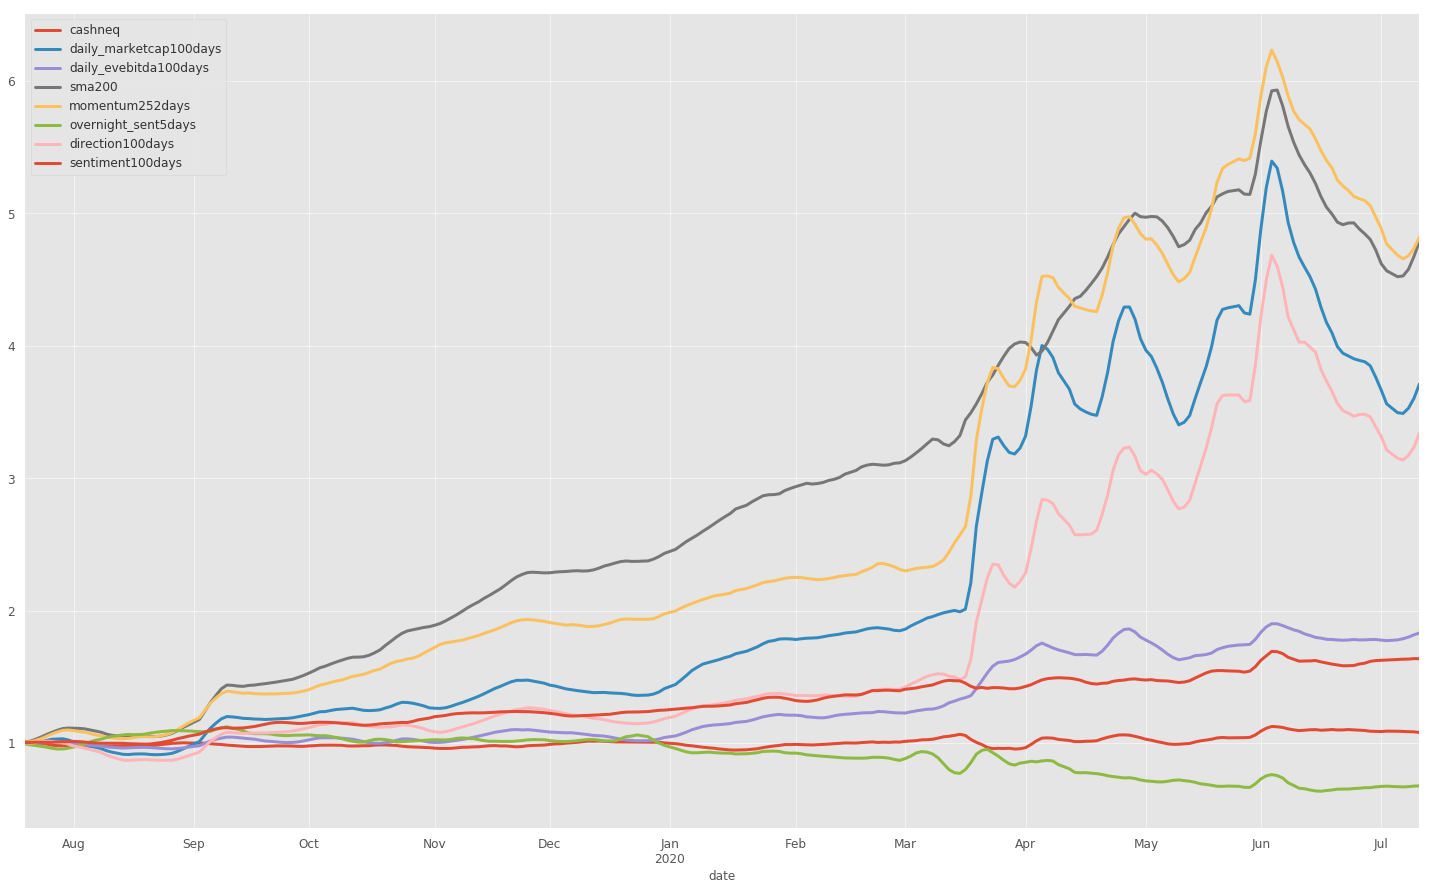

In [66]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25, 15)

ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot(lw=3);

### 5 - 2 - Quantile analysis

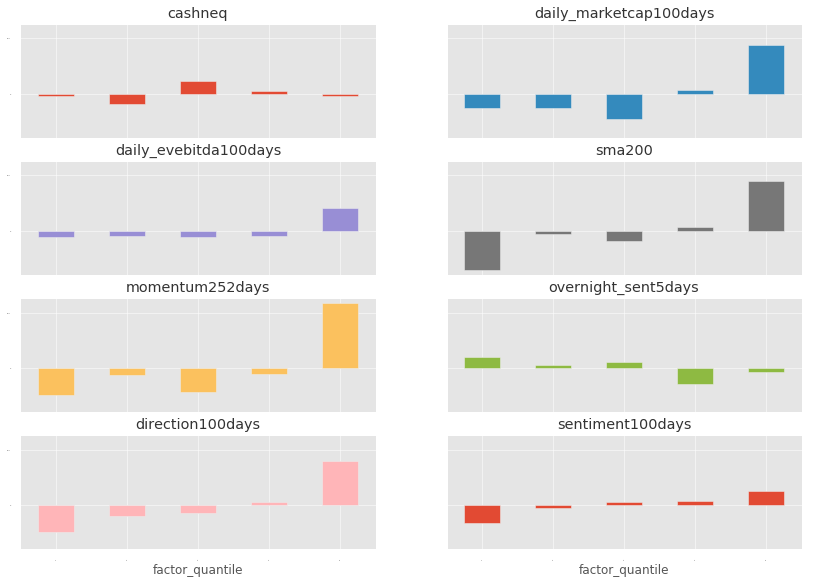

In [67]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(20,2),
    figsize=(14, 50),
    legend=False, fontsize=2);

### 5 - 3 - Factor Rank Autocorrelation

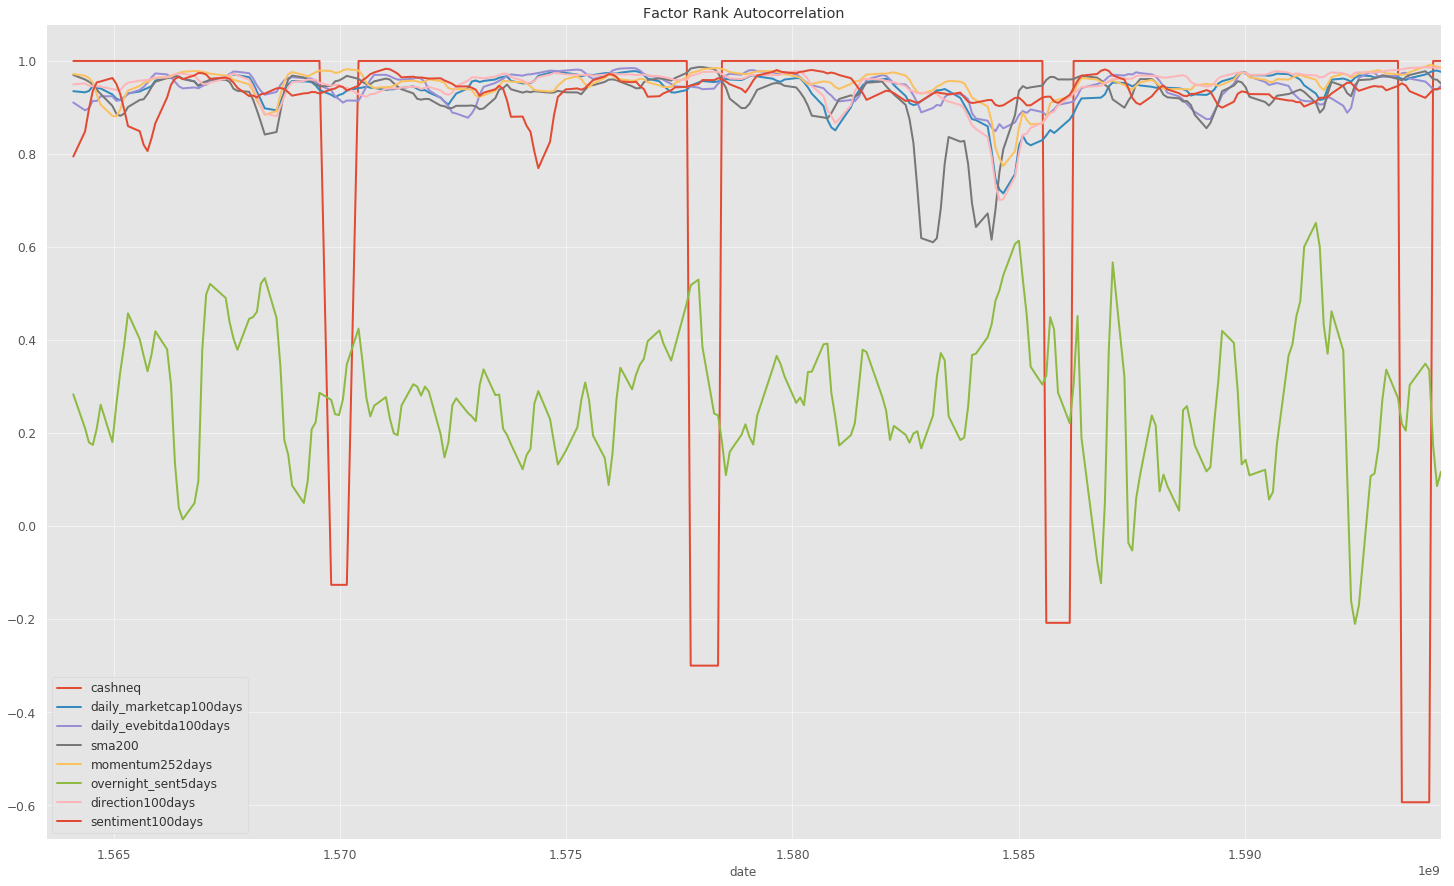

In [68]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data,period=rebalance_period)

ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

### 5 - 4 - Sharpe ratio

In [69]:
def sharpe_ratio(factor_returns, annualization_factor):

    df_sharpe = pd.Series(annualization_factor*factor_returns.mean()/factor_returns.std())
    
    return df_sharpe

In [70]:
daily_annualization_factor = np.sqrt(252)
df_sharpe = sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

In [71]:
df_sharpe.sort_values(ascending=False)

sma200                    8.71
momentum252days           5.71
sentiment100days          5.54
daily_evebitda100days     4.21
daily_marketcap100days    3.61
direction100days          3.37
cashneq                   0.83
overnight_sent5days      -1.65
dtype: float64

# 6 - Combined factors

## 6 - 1 - Combining selceted factors

In [72]:

selected_factors = [
                         'sma200',
                         'daily_marketcap100days',
                         'direction100days',
                         'momentum252days',
                         #'sentiment100days',
                         #'cashneq'
                   ]

print('Selected Factors:\n{} '.format(',\n'.join(selected_factors)))

all_factors = all_factors[selected_factors]

Selected Factors:
sma200,
daily_marketcap100days,
direction100days,
momentum252days 


Time to train full ML pipline: 1.4349324703216553 secs
Accuracy on train set = 50.70%
Predictions: [-1. -1. -1. ... -1. -1. -1.]
Probabilities of class == 1: [49.99995514 49.99995514 49.99995514 ... 49.99995514 49.99995514
 49.99995514]
Accuracy on test set = 50.17%
Log-loss = 0.69315


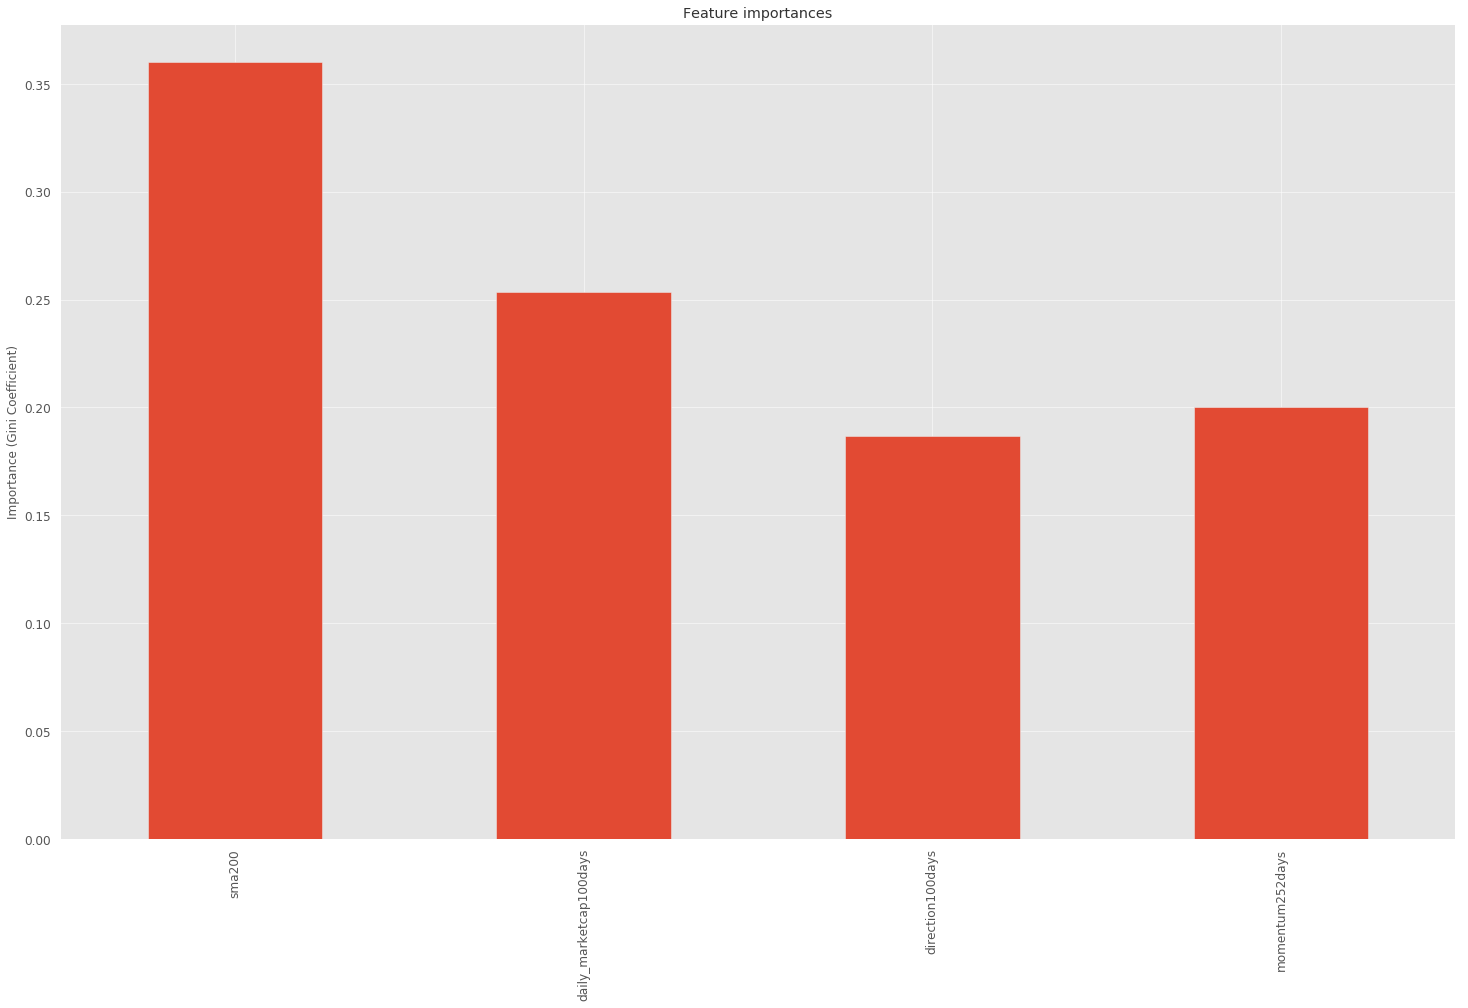

In [73]:
feature_importances = feature_weights.feature_importance(n_fwd_days = rebalance_period, 
                                                         close = close, 
                                                         all_factors = all_factors)

In [74]:
feature_importances

weights
factors                         
sma200                  0.360000
daily_marketcap100days  0.253333
direction100days        0.186667
momentum252days         0.200000

In [75]:
all_factors_copy = all_factors.copy() 

In [76]:
for factor in selected_factors:
    all_factors_copy.loc[:,factor] = feature_importances.loc[factor][0] * all_factors.loc[:,factor]
all_factors_copy.loc[:,'alpha_vector'] = all_factors.sum(axis=1)
all_factors = all_factors_copy  

In [77]:
vec = pd.DataFrame(data=all_factors['alpha_vector'],columns = ['alpha_vector','sector'])
for date in vec.index.levels[0]:
    vec.loc[date,['sector']] = meta_ex_sc_cu.loc[vec.index.levels[1]]['sector'].values
sectors = vec['sector']

In [78]:
vec.shape

(76356, 2)


## 6 - 2 - Creating clean factor data

In [79]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor = all_factors['alpha_vector'], 
                                                          prices = pricing, 
                                                          periods = combined_periods,
                                                          quantiles = qunatile_portions,
                                                          groupby=sectors,
                                                          binning_by_group=False,
                                                          filter_zscore=20,
                                                          max_loss=0.15)

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!


## 6 - 3 - Creating tear sheets 

In [80]:
pf_returns, pf_positions, pf_benchmark = \
al.performance.create_pyfolio_input(factor_data,
                                       period='{}D'.format(rebalance_period),
                                       capital=10000,
                                       long_short=True,
                                       group_neutral=False,
                                       equal_weight=False,
                                       #quantiles=[1,2,4,5],
                                       groups=sectors,
                                       benchmark_period='{}D'.format(rebalance_period))

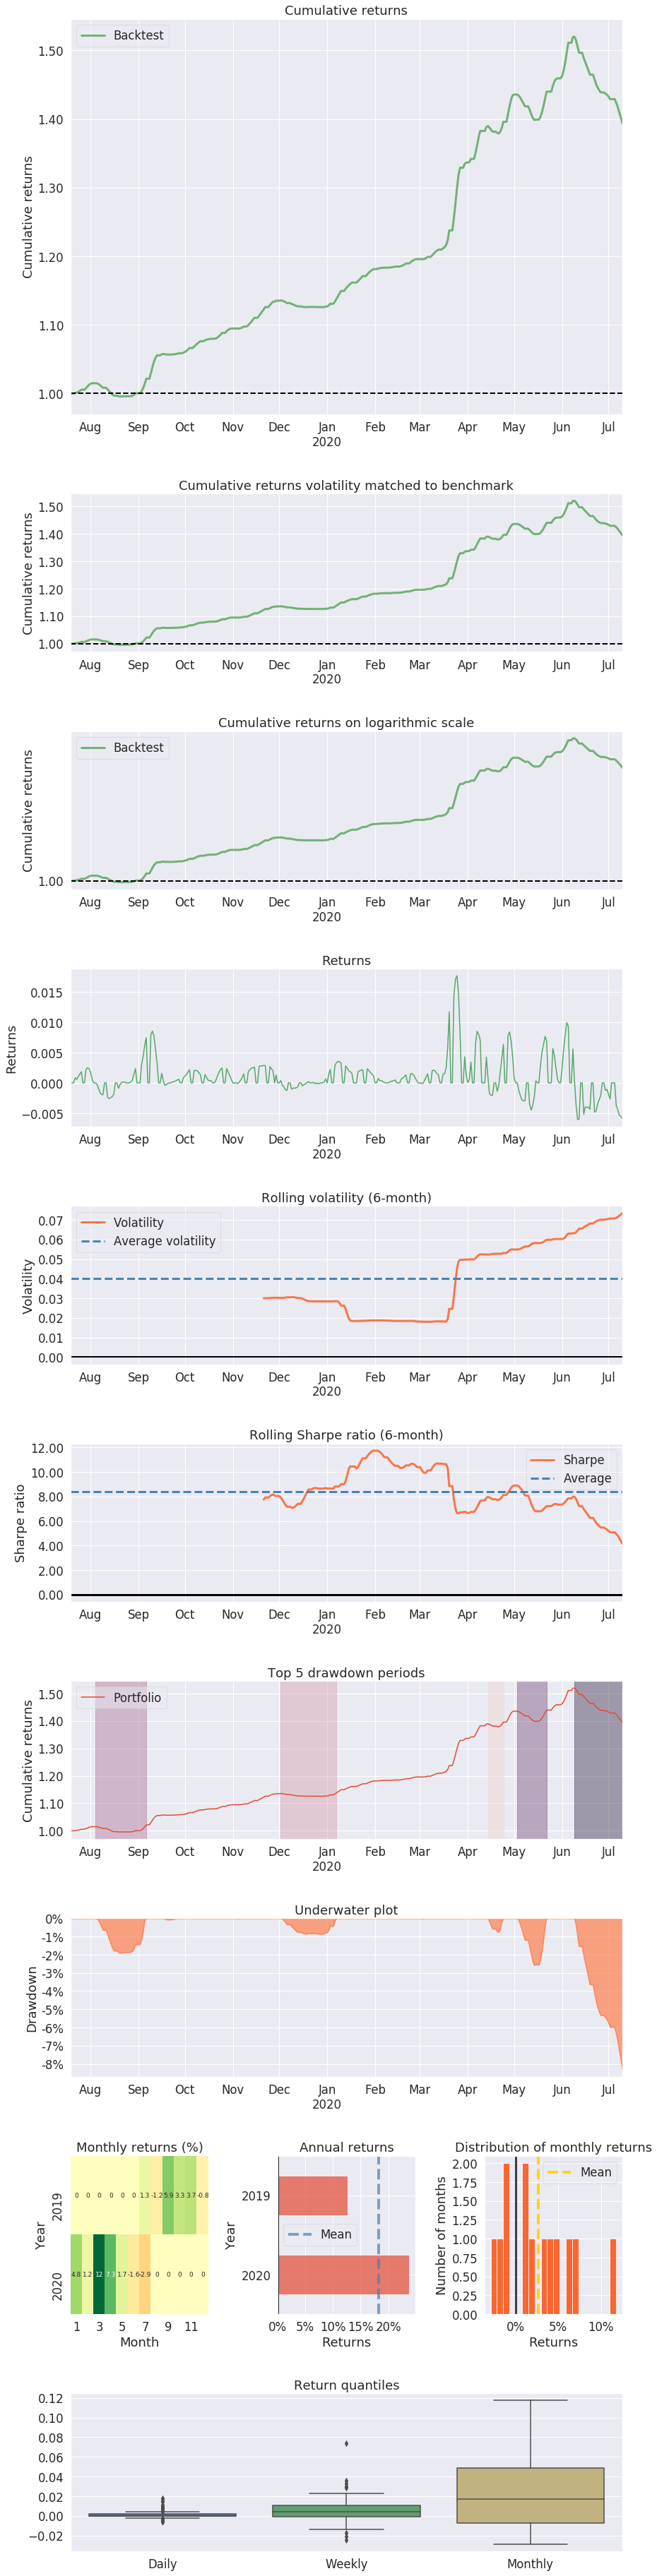

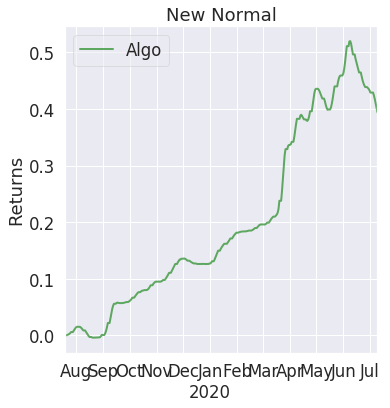

In [81]:
pf.create_full_tear_sheet(pf_returns)

Quantiles Statistics


min        max      mean       std  count   count %
factor_quantile                                                           
1               -11.199718  -3.389840 -5.487255  1.436232   3146  4.290429
2                -8.454511  -2.590881 -4.154884  0.978791   2904  3.960396
3                -6.915214  -2.184721 -3.499747  0.848259   2904  3.960396
4                -6.279854  -1.932727 -3.038674  0.758993   2904  3.960396
5                -5.590479  -1.587987 -2.653717  0.684116   2904  3.960396
6                -4.869899  -1.275560 -2.285155  0.616353   2904  3.960396
7                -4.373049  -1.056542 -1.959413  0.556553   2904  3.960396
8                -4.022284  -0.741832 -1.656617  0.496291   2904  3.960396
9                -3.449929  -0.508125 -1.355132  0.450287   2904  3.960396
10               -2.973347  -0.283244 -1.054497  0.413165   2904  3.960396
11               -2.491050   0.113633 -0.754254  0.393603   2904  3.960396
12               -2.030757   0.339471 -0.445049  0.377503   2904  3.960396
13               -1.594790   0.683149 -0.119793  0.376820   3146  4.290429
14               -1.117226   1.138462  0.207501  0.384694   2904  3.960396
15               -0.845172   1.540492  0.521701  0.407712   2904  3.960396
16               -0.244682   1.978907  0.824067  0.428930   2904  3.960396
17                0.205456   2.429955  1.136160  0.443804   2904  3.960396
18                0.604214   2.839366  1.446964  0.451879   2904  3.960396
19                0.881793   3.183979  1.773190  0.456910   2904  3.960396
20                1.250783   3.726291  2.126416  0.457155   2904  3.960396
21                1.681497   4.486869  2.542256  0.486339   2904  3.960396
22                2.142835   5.049626  3.020177  0.527193   2904  3.960396
23                2.529501   6.045341  3.636954  0.607472   2904  3.960396
24                3.079758   7.300294  4.448702  0.712803   2904  3.960396
25                3.732608  13.678750  5.981169  1.244759   3146  4.290429

Returns Analysis


3D       5D      10D
Ann. alpha                                       0.394    0.377    0.348
beta                                             0.243    0.217    0.098
Mean Period Wise Return Top Quantile (bps)     101.621   97.671   91.248
Mean Period Wise Return Bottom Quantile (bps)  -57.432  -54.944  -43.055
Mean Period Wise Spread (bps)                  159.053  152.117  133.144

<Figure size 1800x1080 with 0 Axes>

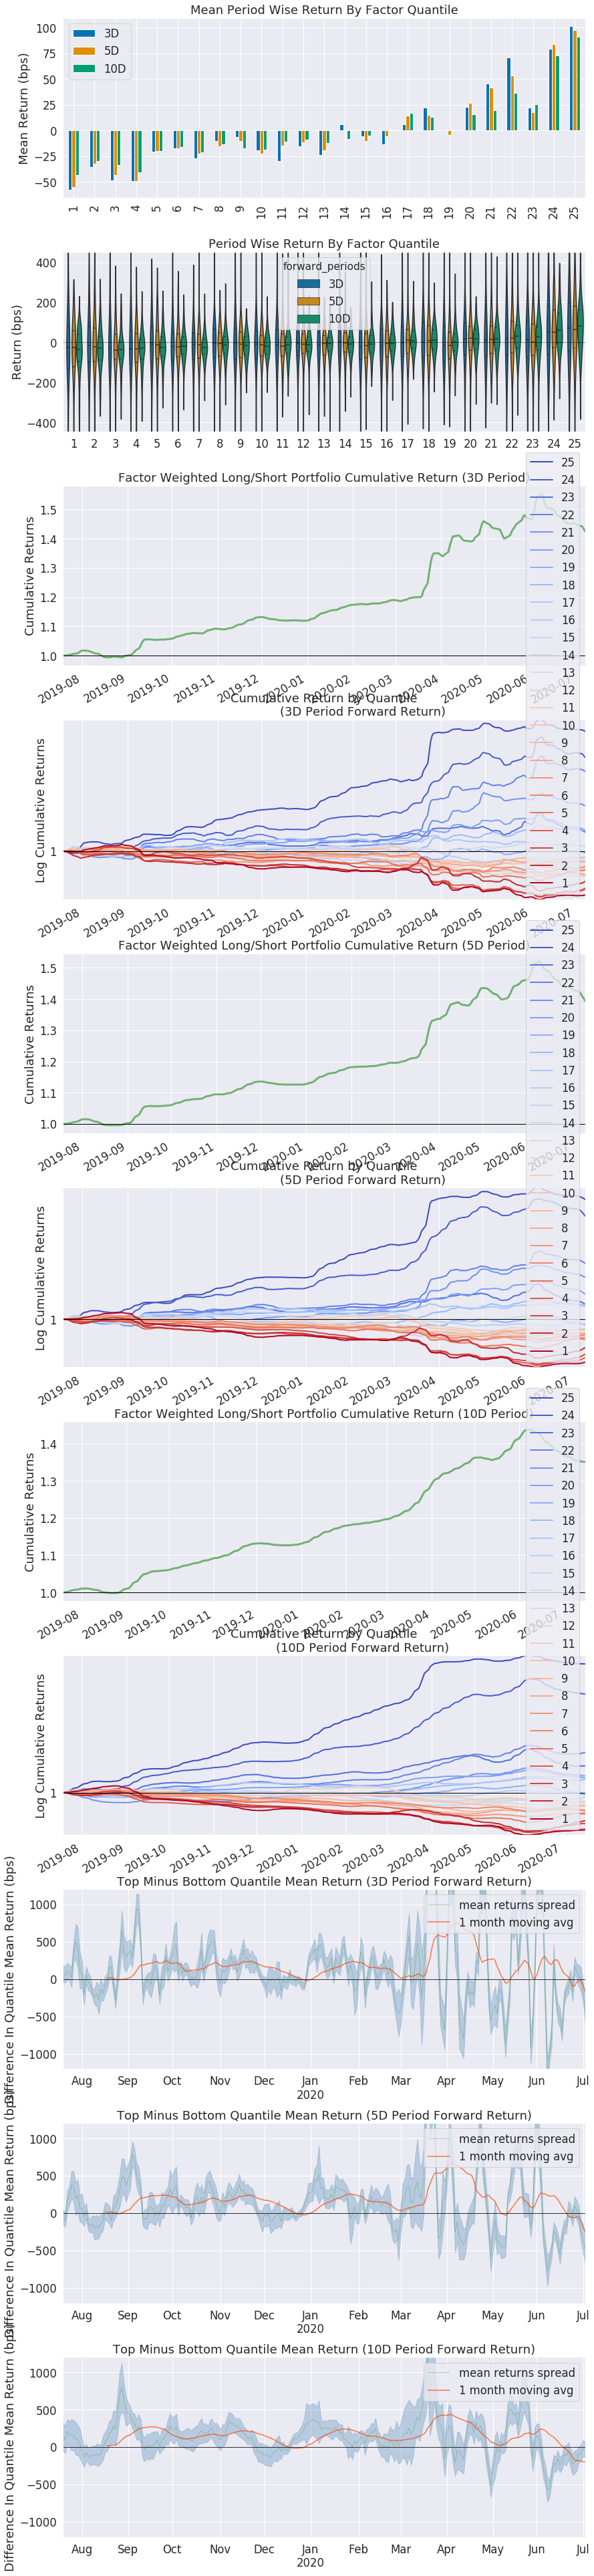

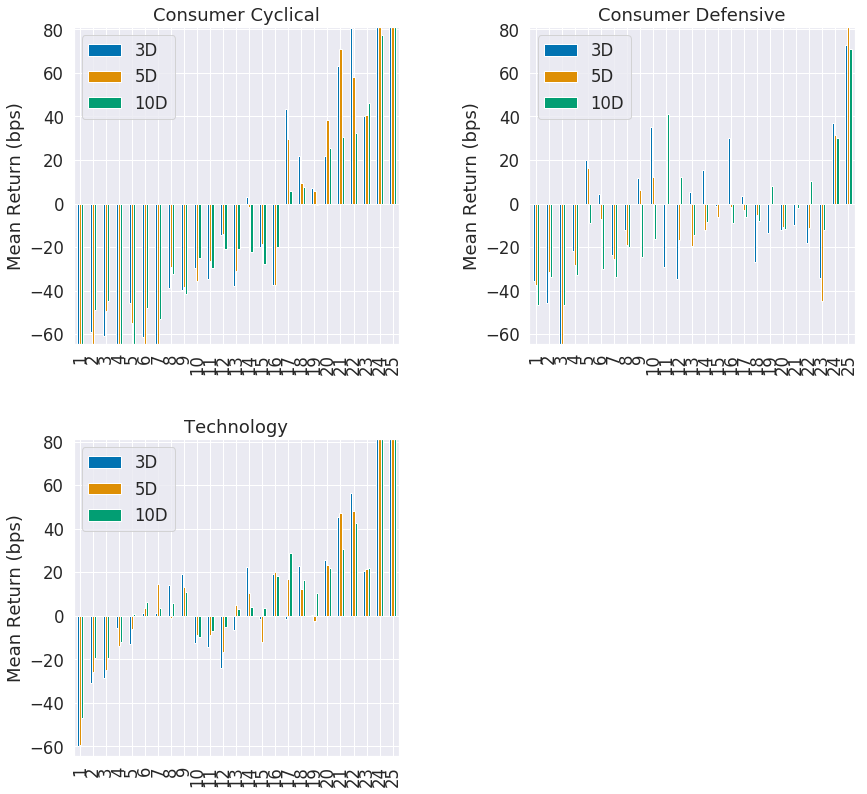

Information Analysis


3D     5D    10D
IC Mean           0.046  0.062  0.105
IC Std.           0.218  0.231  0.237
Risk-Adjusted IC  0.211  0.269  0.444
t-stat(IC)        3.284  4.179  6.908
p-value(IC)       0.001  0.000  0.000
IC Skew          -0.061 -0.099 -0.496
IC Kurtosis       0.119 -0.062  0.029

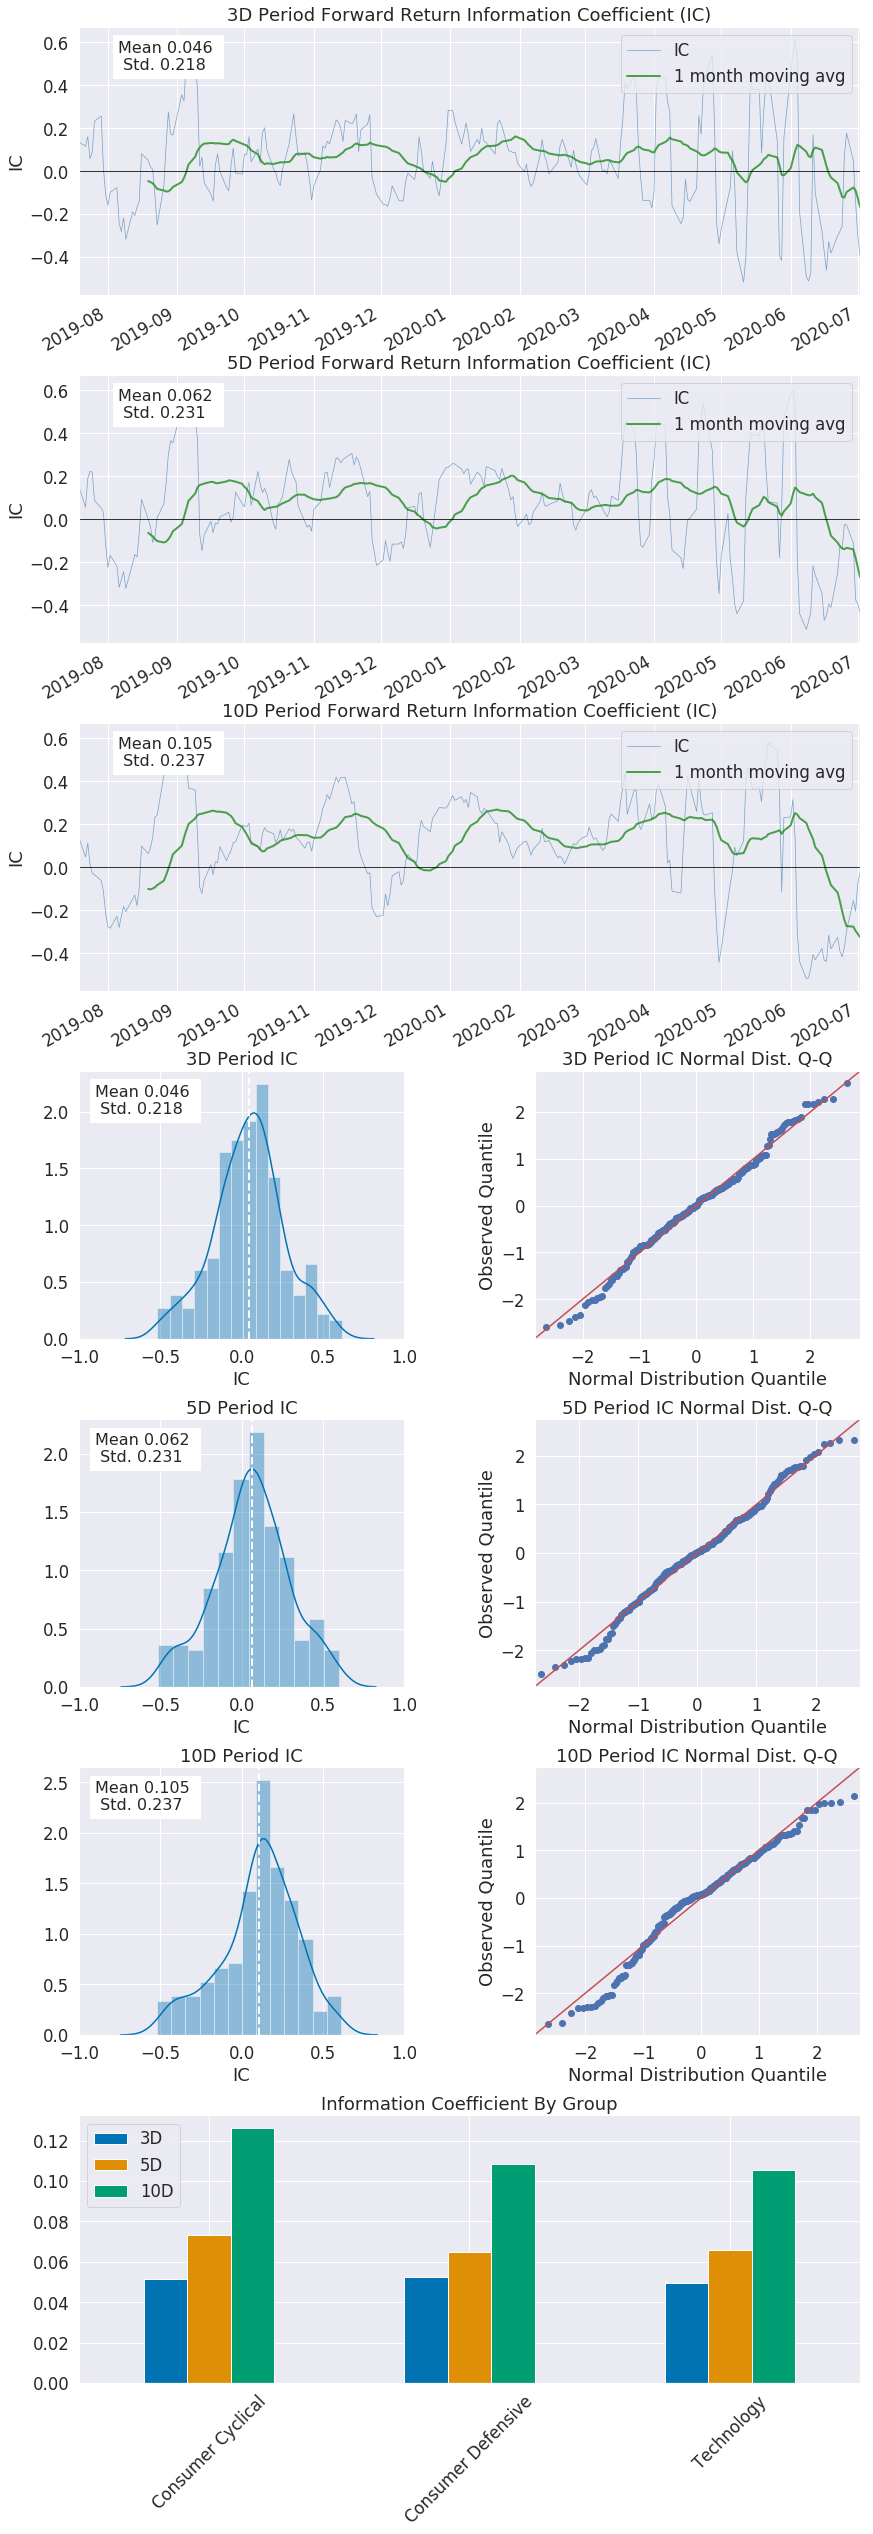

Turnover Analysis


10D     3D     5D
Quantile 1 Mean Turnover    0.433  0.198  0.286
Quantile 2 Mean Turnover    0.749  0.491  0.612
Quantile 3 Mean Turnover    0.821  0.595  0.707
Quantile 4 Mean Turnover    0.855  0.660  0.762
Quantile 5 Mean Turnover    0.865  0.703  0.787
Quantile 6 Mean Turnover    0.870  0.731  0.807
Quantile 7 Mean Turnover    0.871  0.735  0.822
Quantile 8 Mean Turnover    0.895  0.755  0.827
Quantile 9 Mean Turnover    0.886  0.767  0.844
Quantile 10 Mean Turnover   0.897  0.760  0.839
Quantile 11 Mean Turnover   0.895  0.756  0.830
Quantile 12 Mean Turnover   0.889  0.750  0.823
Quantile 13 Mean Turnover   0.906  0.750  0.838
Quantile 14 Mean Turnover   0.890  0.758  0.828
Quantile 15 Mean Turnover   0.891  0.768  0.837
Quantile 16 Mean Turnover   0.902  0.764  0.855
Quantile 17 Mean Turnover   0.893  0.760  0.841
Quantile 18 Mean Turnover   0.890  0.752  0.833
Quantile 19 Mean Turnover   0.866  0.726  0.799
Quantile 20 Mean Turnover   0.866  0.714  0.797
Quantile 21 Mean Turnover   0.855  0.685  0.791
Quantile 22 Mean Turnover   0.843  0.641  0.755
Quantile 23 Mean Turnover   0.795  0.586  0.693
Quantile 24 Mean Turnover   0.729  0.485  0.604
Quantile 25 Mean Turnover   0.451  0.208  0.301

3D     5D    10D
Mean Factor Rank Autocorrelation  0.971  0.937  0.857

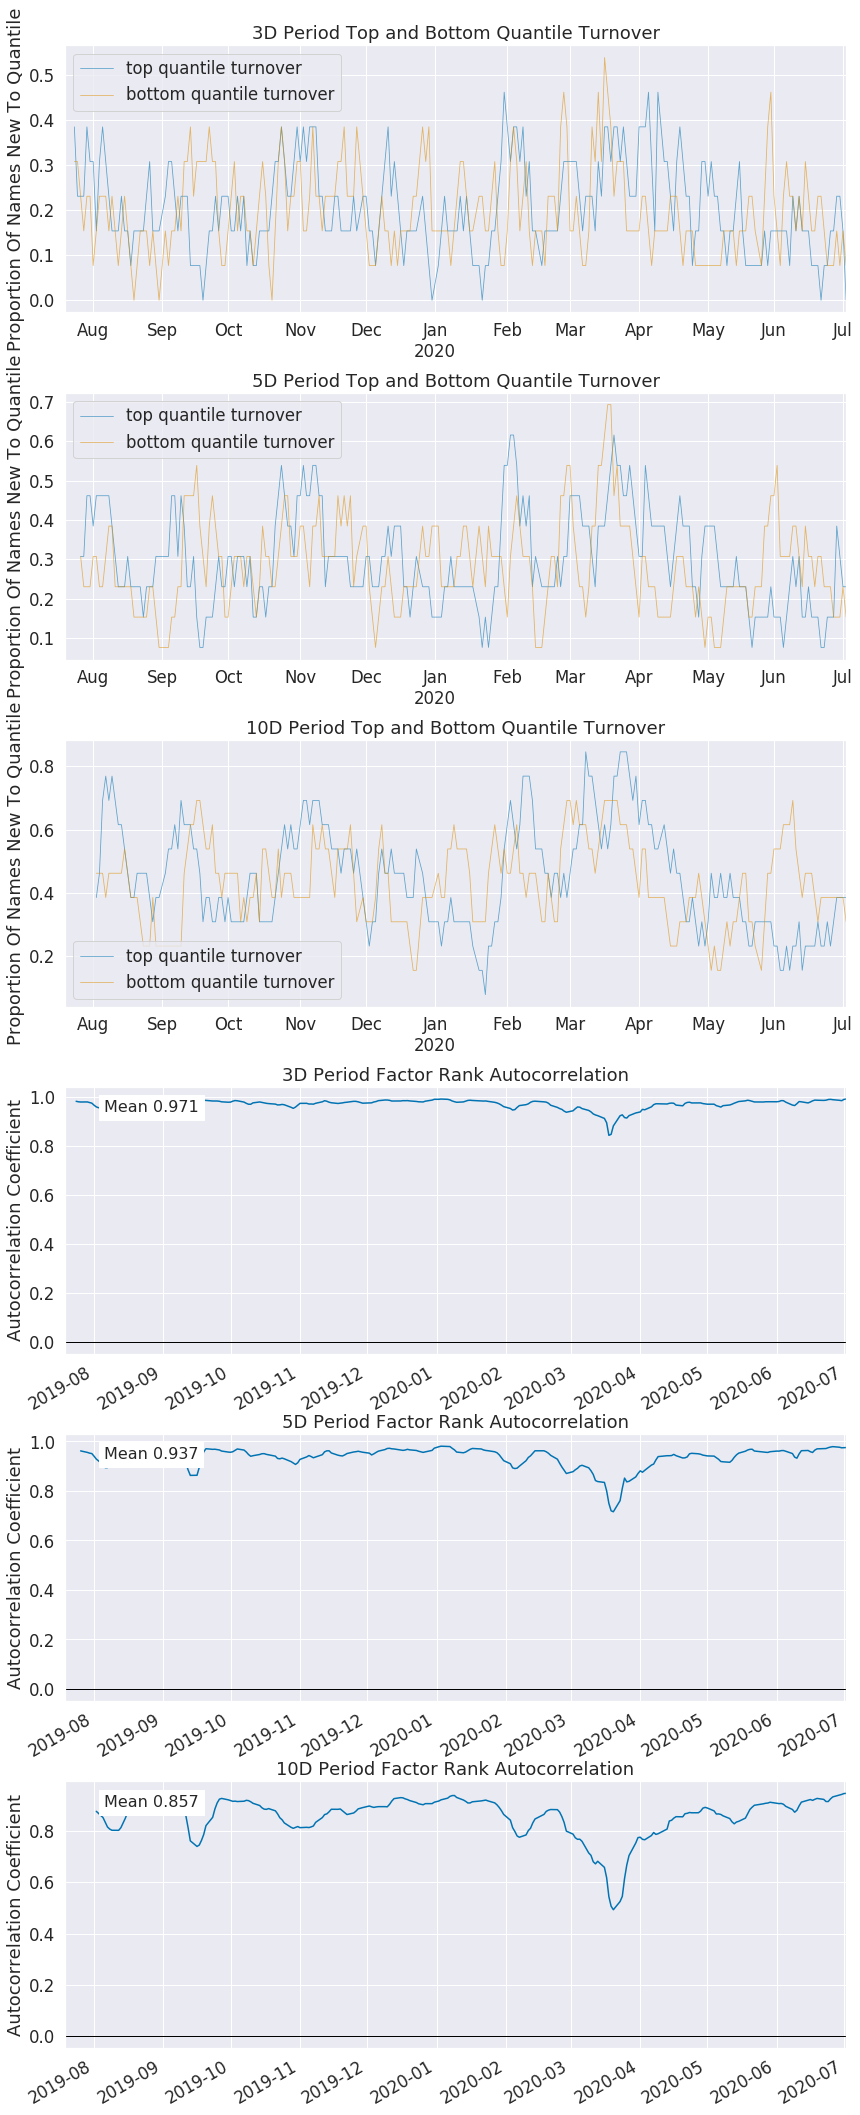

In [82]:
al.tears.create_full_tear_sheet(factor_data, by_group=True, long_short=True, group_neutral=False);

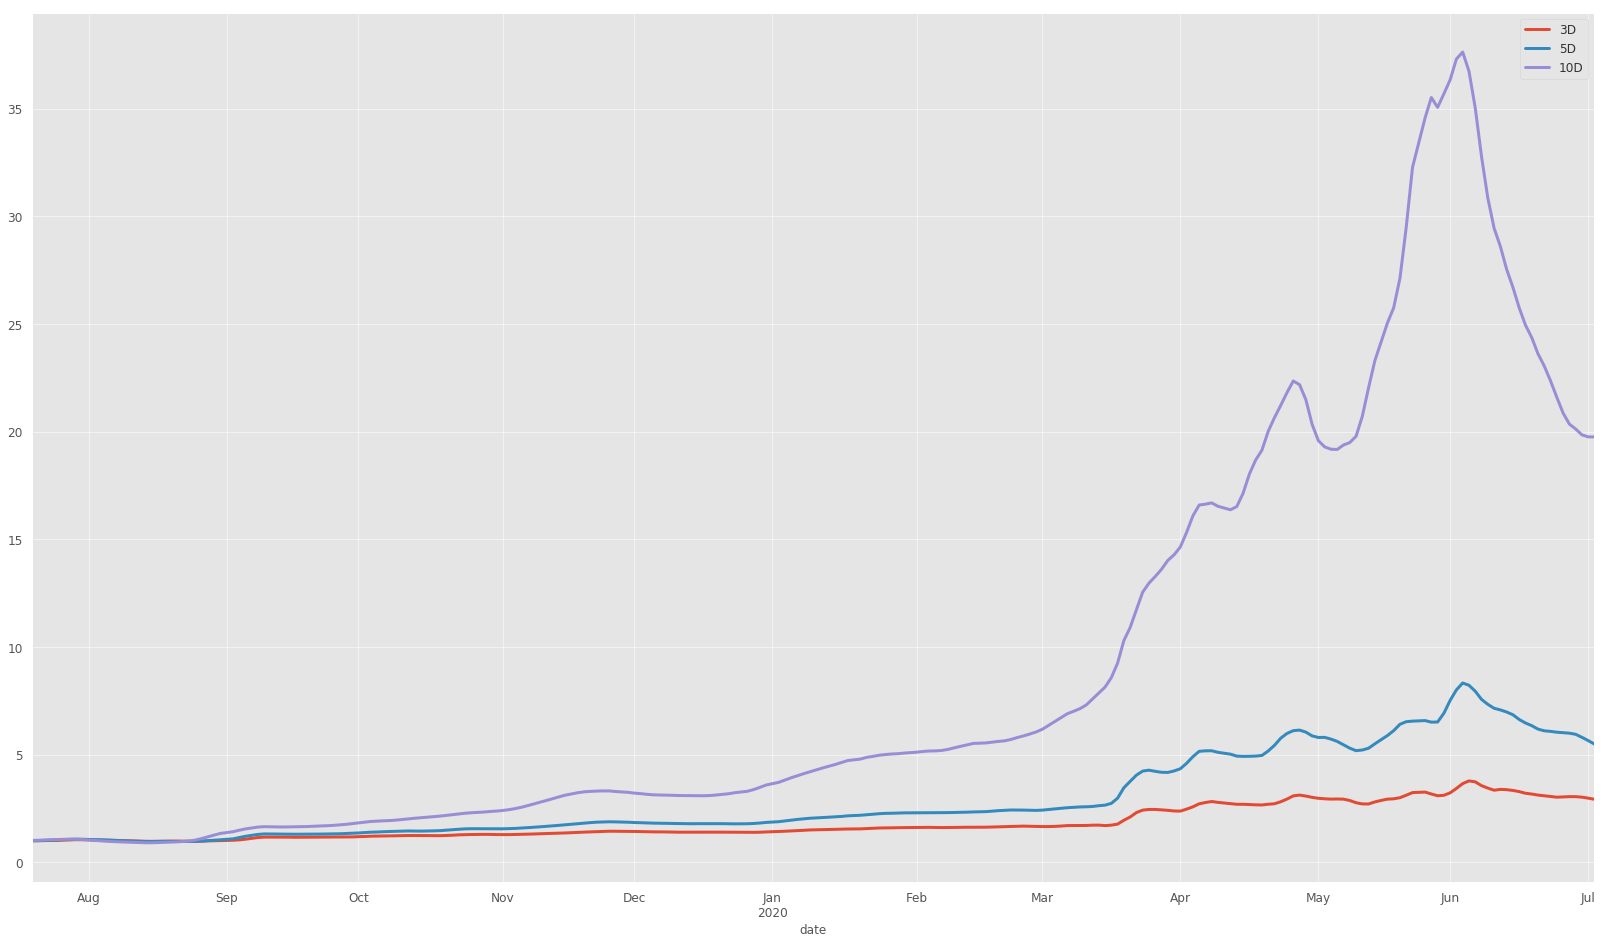

In [83]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (28, 16)

ls_factor_returns = al.performance.factor_returns(factor_data)

(1+ls_factor_returns).cumprod().plot(lw=3);

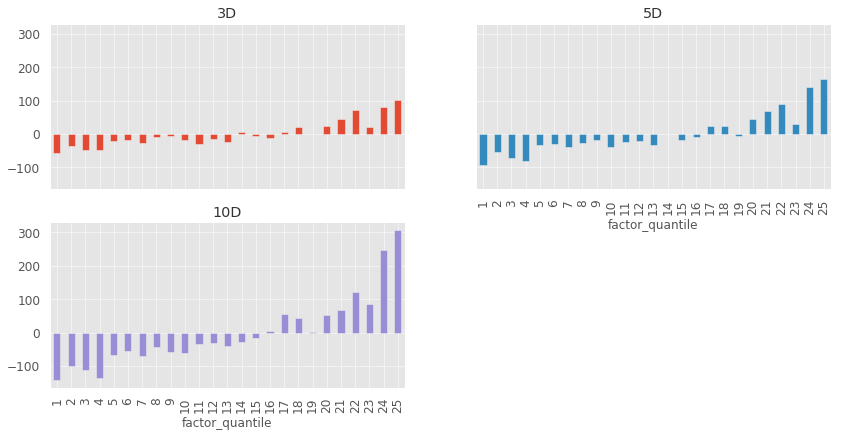

In [84]:
qr_factor_returns = pd.DataFrame()

qr_factor_returns = al.performance.mean_return_by_quantile(factor_data)[0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

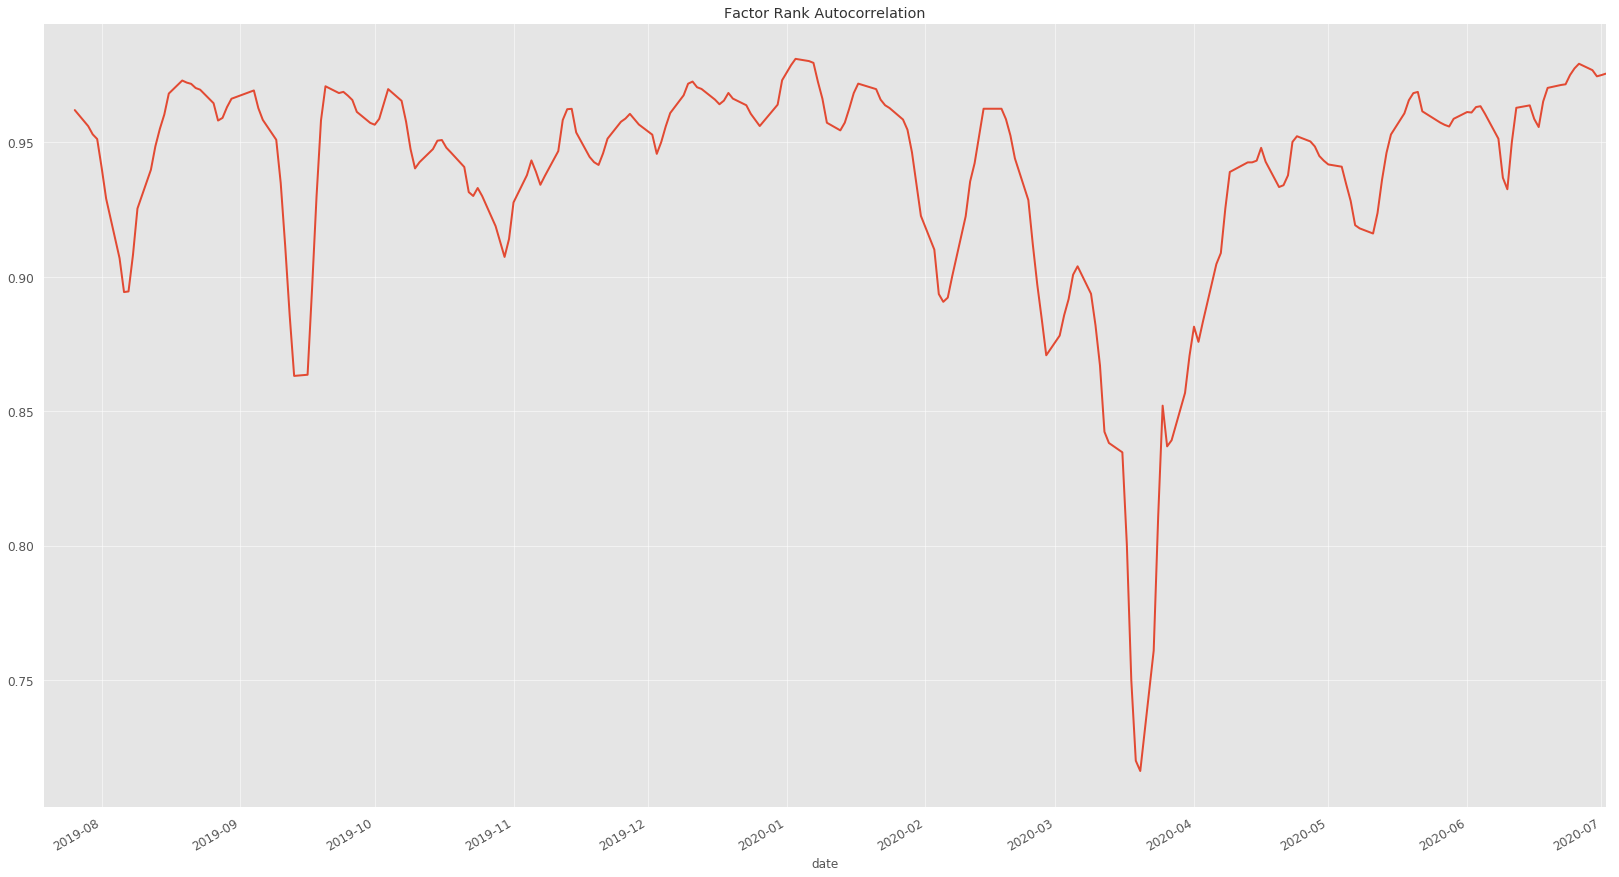

In [85]:
ls_FRA = pd.DataFrame()
ls_FRA = al.performance.factor_rank_autocorrelation(factor_data, period = rebalance_period)
ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

In [86]:
ls_FRA.mean()

0.9369166721526314

In [87]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

3D     4.12
5D     5.13
10D    7.90
dtype: float64

# 7 -  Risk analysis for equal weights

In [88]:
assets = all_factors.index.levels[1]

In [89]:
all_weights = pd.DataFrame(np.repeat(1/len(assets), len(assets)), assets)

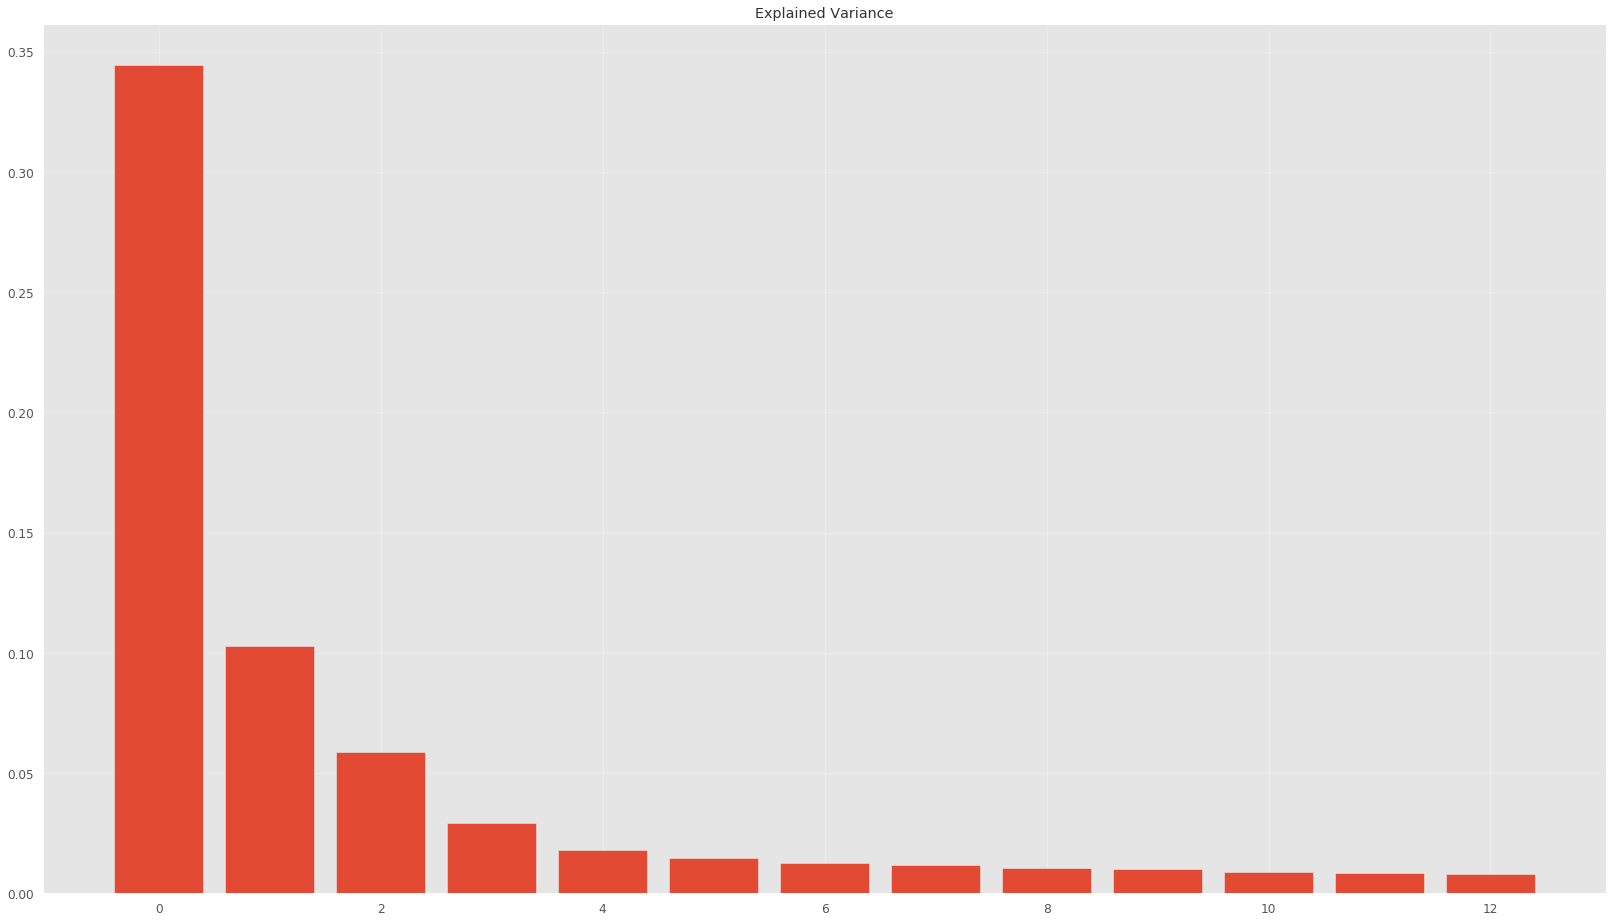

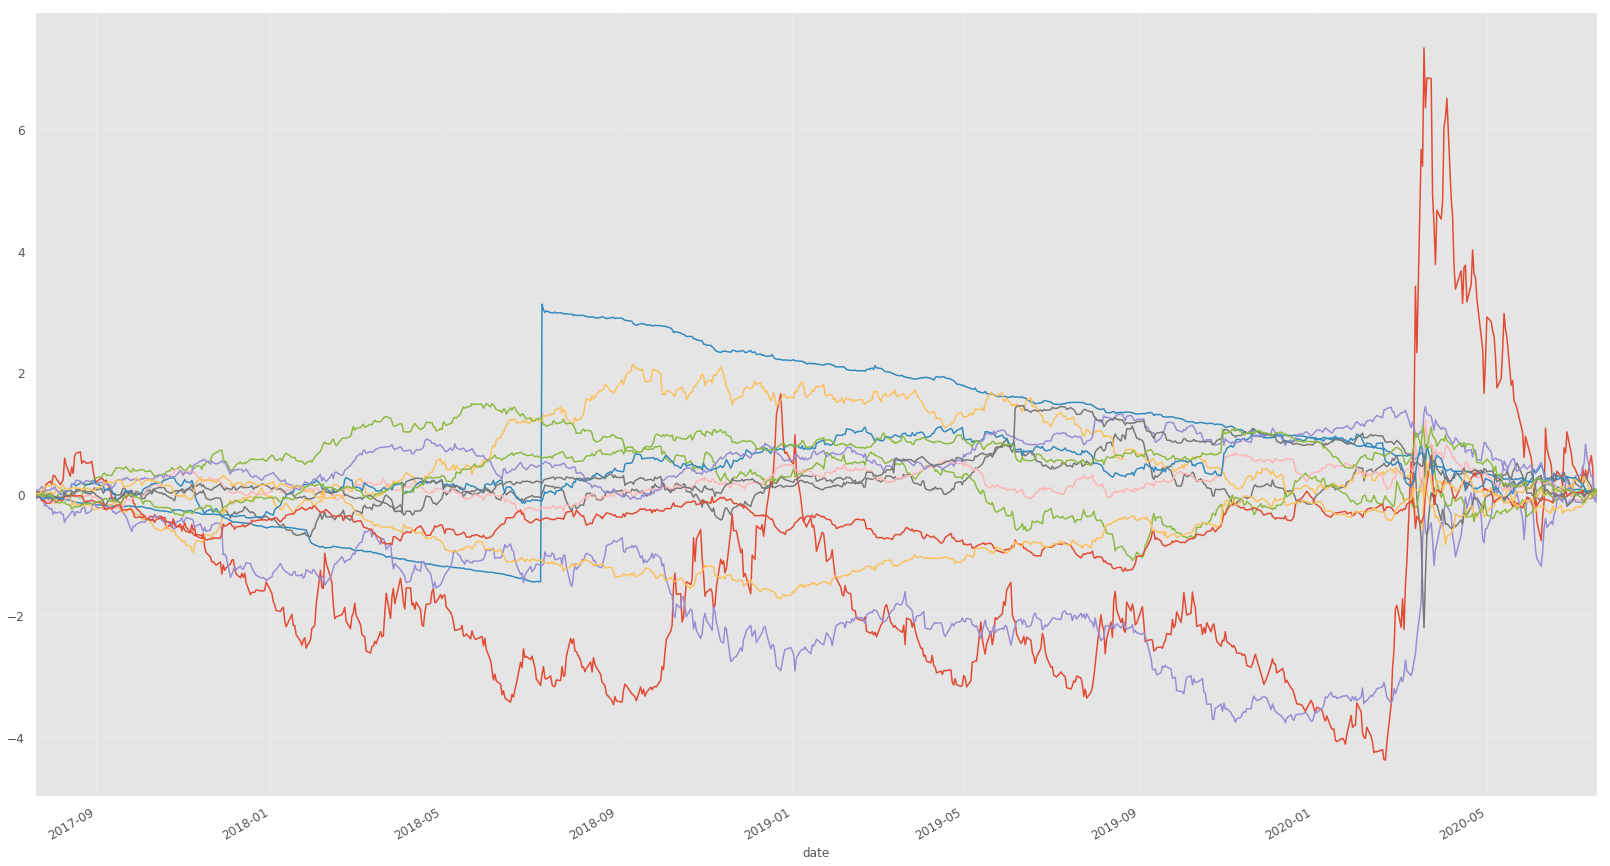

In [90]:
predicted_portfolio_risk,Risk_Model = risk_model.portfolio_risk(close[assets],num_factor_exposures=13,weights=all_weights)

In [91]:
print ('Predicted Risk: {} %'.format(np.round((predicted_portfolio_risk*100),2)))

Predicted Risk: 26.44 %


# 8 - Integrating factor data to optimzer

In [92]:
optimal = pd.DataFrame(index = all_factors.index.levels[0], columns = all_factors.index.levels[1])
for date in all_factors.index.levels[0]:
    
    x = all_factors[['alpha_vector']].loc[date.date(),:]
    optimal.loc[date] = risk_model\
                          .OptimalHoldingsRegularization(lambda_reg = lambda_reg,
                                                         risk_cap = risk_cap).find(
                                                            x, 
                                                            Risk_Model['factor_betas'], 
                                                            Risk_Model['factor_cov_matrix'], 
                                                            Risk_Model['idiosyncratic_var_vector']).values.flatten()
    

    
optimal = optimal.astype(np.float)
optimal_stacked = optimal.stack().to_frame('optimal_weights')

In [93]:
assert optimal_stacked.shape[0] == vec.shape[0]

## Quantilize data

In [94]:
quantile_optimal_stacked = pd.DataFrame(index = optimal_stacked.index, 
                                        columns = ['optimal_weights','quantile','sector'])
qunatiles = np.linspace(0,1,qunatile_portions+1)
labels = [i+1 for i in range(len(qunatiles)-1)]

for date in optimal_stacked.index.levels[0]:
    
    x = optimal_stacked['optimal_weights'].loc[date.date(),:]
    
    quantile_optimal_stacked.loc[date,'quantile'] = pd.qcut(x, qunatiles, 
                                                            labels = labels)
    
quantile_optimal_stacked.loc[:,'optimal_weights'] = optimal_stacked['optimal_weights']
quantile_optimal_stacked.loc[:,'sector'] = vec['sector']

In [95]:
quantile_optimal_stacked.shape

(76356, 3)

In [96]:
try:
    q_list = []
    for i in quantile_to_analyse:
        q_list.append((quantile_optimal_stacked['quantile'] == i))

    df_merge = q_list[0]
    for df in q_list[1:]:       
        df_merge = df_merge ^ df
    
    q_final_vector = quantile_optimal_stacked[df_merge]
    
except:
    
    print ('no specific quantile selected')
    q_final_vector = quantile_optimal_stacked

In [97]:
remaining_quantiles = list(set(q_final_vector.loc[:,'quantile'].values))

In [98]:
rows = q_final_vector.shape[0]

## Sector Selection

In [99]:
try:
    drop_rows_list = []
    for i in drop_long_sec:
        drop_rows_list.append((q_final_vector.sector == i) & (q_final_vector['quantile'] == labels[-1]))

    for i in drop_short_sec:
        drop_rows_list.append((q_final_vector.sector == i) & (q_final_vector['quantile'] == labels[0]))

    if len(drop_rows_list) == 1:
        df_merge = drop_rows_list[0]
    else:
        df_merge = drop_rows_list[0]
        
        for df in drop_rows_list[1:]:       
            df_merge = df_merge ^ df

    final_vector = q_final_vector[~df_merge]
    sectors = final_vector['sector']
    
    assert list(final_vector[(final_vector['quantile'] == labels[-1]) & (final_vector['sector'] == drop_long_sec[0])].values) == []
    assert list(final_vector[(final_vector['quantile'] == labels[0]) & (final_vector['sector'] == drop_short_sec[0])].values) == []

except:
    final_vector = q_final_vector
    sectors = final_vector['sector']

In [100]:
print ('{} rows dropped from final vector'.format(rows - final_vector.shape[0]))

0 rows dropped from final vector


## Balancing to long/short leverage target

In [101]:
try:
    for date in final_vector.index.levels[0]:

        long_balance = np.abs(final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0].sum())
        short_balance = np.abs(final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0].sum())

        long_ratio = percent_long_leverage_target / long_balance
        short_ratio = percent_short_leverage_target / short_balance

        final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0] = final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0] * long_ratio
        final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0] = final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0] * short_ratio

except:
    
    pass

## 9 - 1 - Creating clean factor data

In [102]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor = final_vector['optimal_weights'], 
                                                          prices = pricing, 
                                                          periods = combined_periods,
                                                          quantiles = len(remaining_quantiles),
                                                          groupby=sectors,
                                                          binning_by_group=False,
                                                          filter_zscore=20,
                                                          max_loss=0.15)

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!


In [103]:
rows = factor_data.shape[0]

In [104]:
# Sector Selection
try:
    drop_rows_list = []
    for i in drop_long_sec:
        drop_rows_list.append((factor_data.group == i) & (factor_data['factor_quantile'] == 2))

    for i in drop_short_sec:
        drop_rows_list.append((factor_data.group == i) & (factor_data['factor_quantile'] == 1))
    
    if len(drop_rows_list) == 1:
        df_merge = drop_rows_list[0]
    else:
        df_merge = drop_rows_list[0]
        
        for df in drop_rows_list[1:]:       
            df_merge = df_merge ^ df

    factor_data = factor_data[~df_merge]
    sectors = factor_data['group']
    
except:
    
    sectors = factor_data['group']

In [105]:
print ('{} rows dropped from factor data'.format(rows - factor_data.shape[0]))

0 rows dropped from factor data


## 8 - 3 - Creating tear sheets 

In [106]:
pf_returns, pf_positions, pf_benchmark = \
al.performance.create_pyfolio_input(factor_data,
                                   period= '{}D'.format(rebalance_period),
                                   capital=1,
                                   long_short=True,
                                   group_neutral=False,
                                   equal_weight=False,
                                   groups=sectors,
                                   #quantiles=[1,5],
                                   benchmark_period='{}D'.format(rebalance_period))

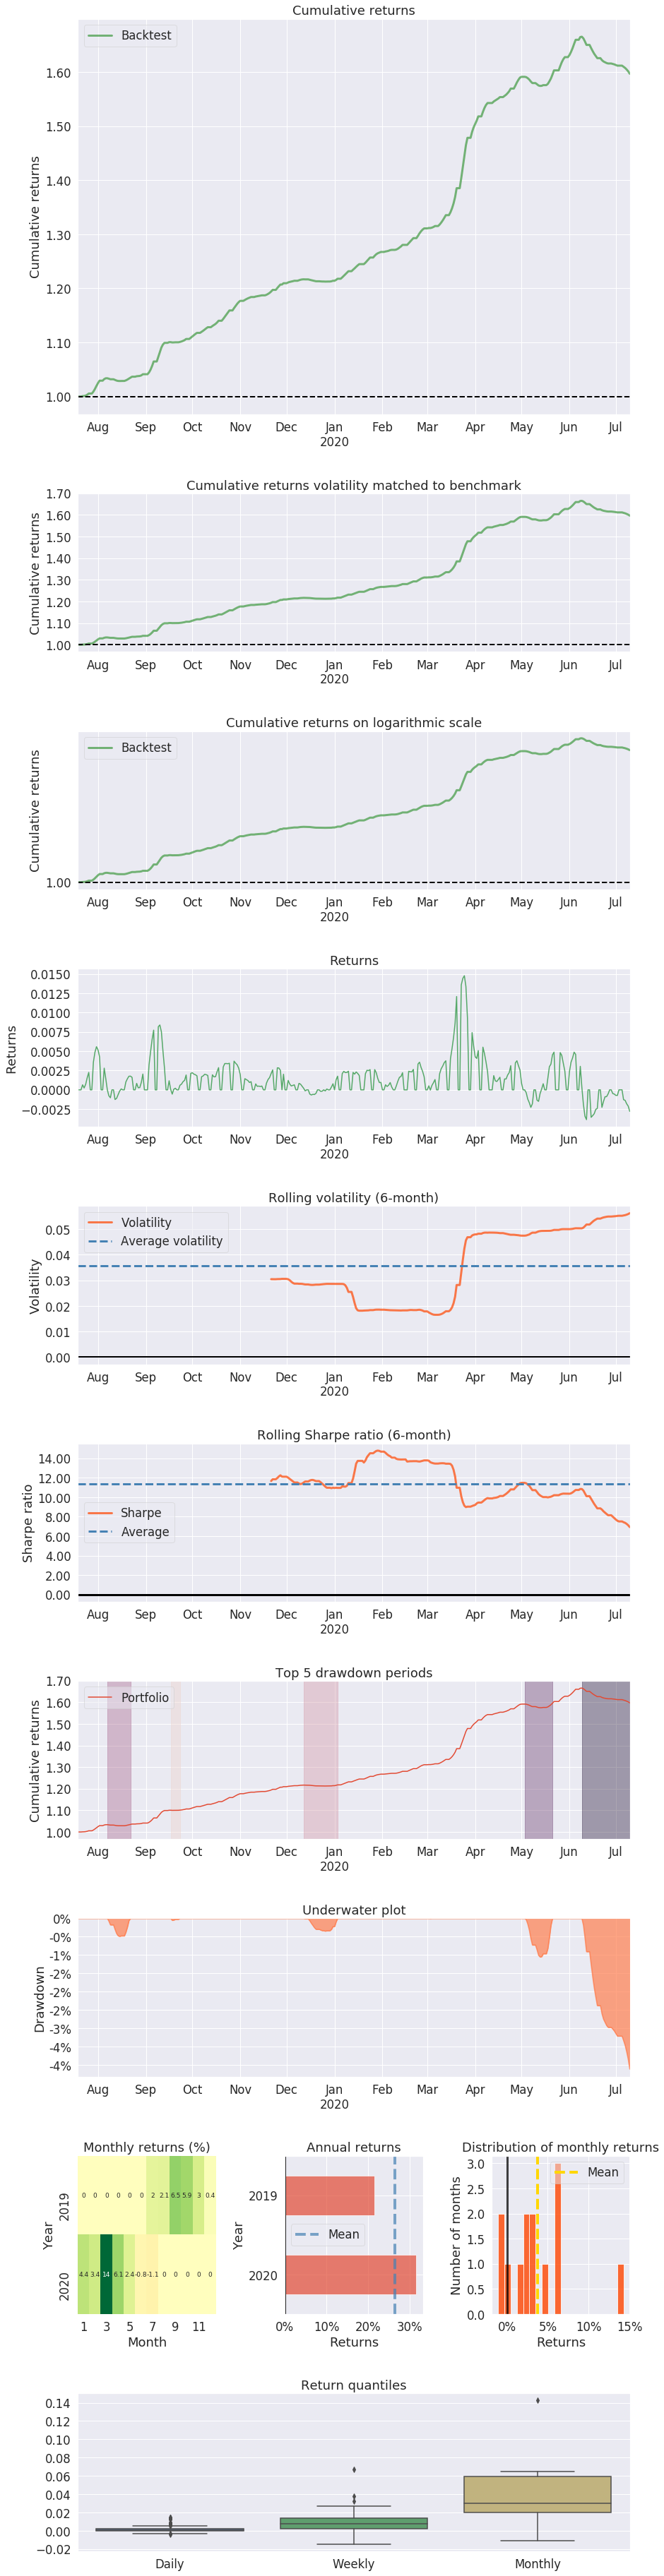

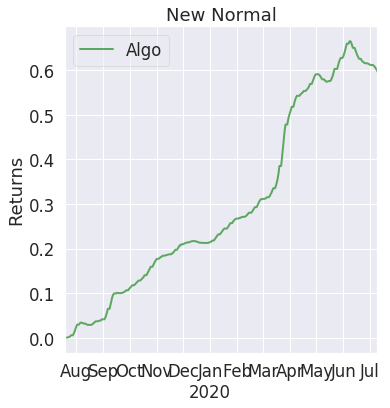

In [107]:
pf.create_full_tear_sheet(pf_returns)

Quantiles Statistics


min       max      mean       std  count  count %
factor_quantile                                                        
1               -0.134312 -0.001655 -0.030769  0.019521   3146     50.0
2                0.003961  0.193795  0.046154  0.028802   3146     50.0

Returns Analysis


3D       5D      10D
Ann. alpha                                       0.583    0.590    0.579
beta                                             0.117    0.109    0.061
Mean Period Wise Return Top Quantile (bps)      57.614   57.281   54.765
Mean Period Wise Return Bottom Quantile (bps)  -57.614  -57.500  -55.474
Mean Period Wise Spread (bps)                  115.227  114.819  110.318

<Figure size 2016x1152 with 0 Axes>

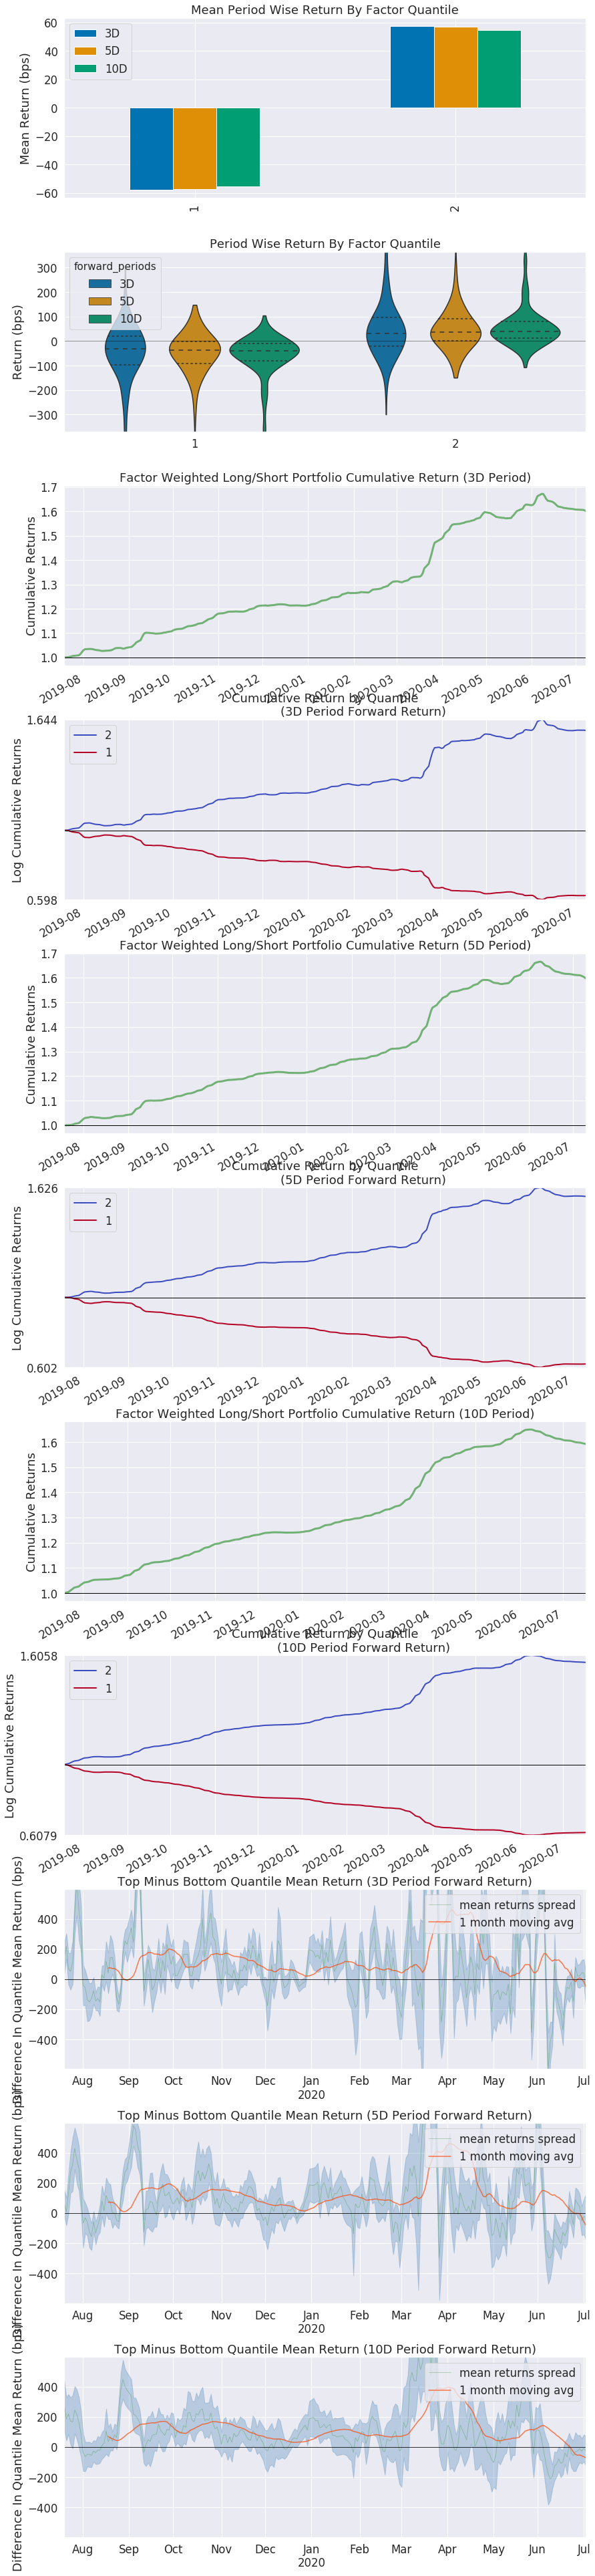

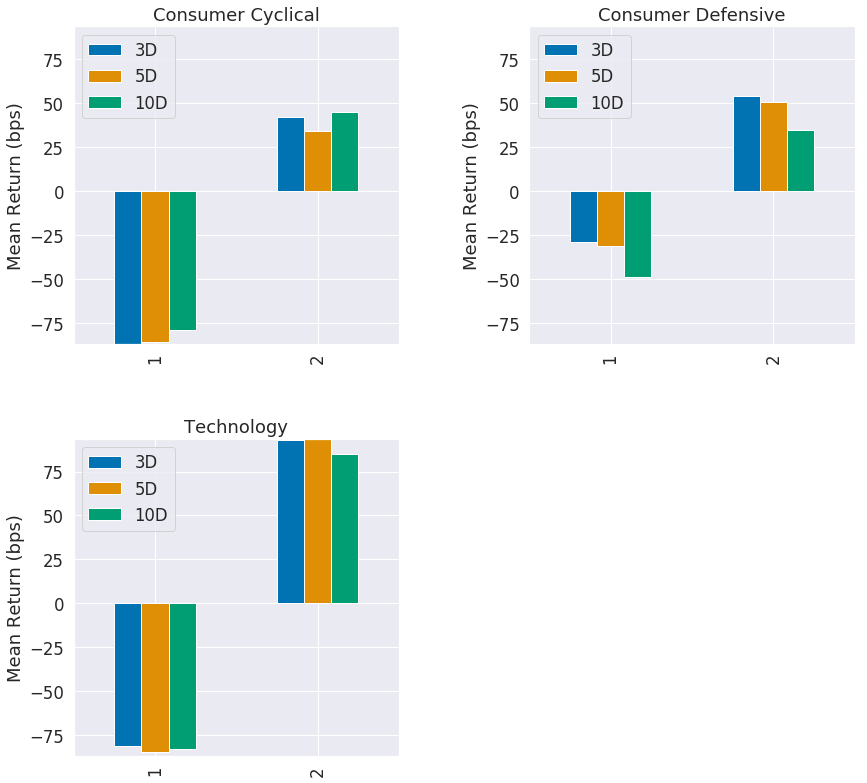

Information Analysis


3D     5D     10D
IC Mean           0.105  0.148   0.229
IC Std.           0.247  0.257   0.271
Risk-Adjusted IC  0.427  0.576   0.843
t-stat(IC)        6.650  8.958  13.112
p-value(IC)       0.000  0.000   0.000
IC Skew          -0.111 -0.118  -0.411
IC Kurtosis      -0.116 -0.223  -0.195

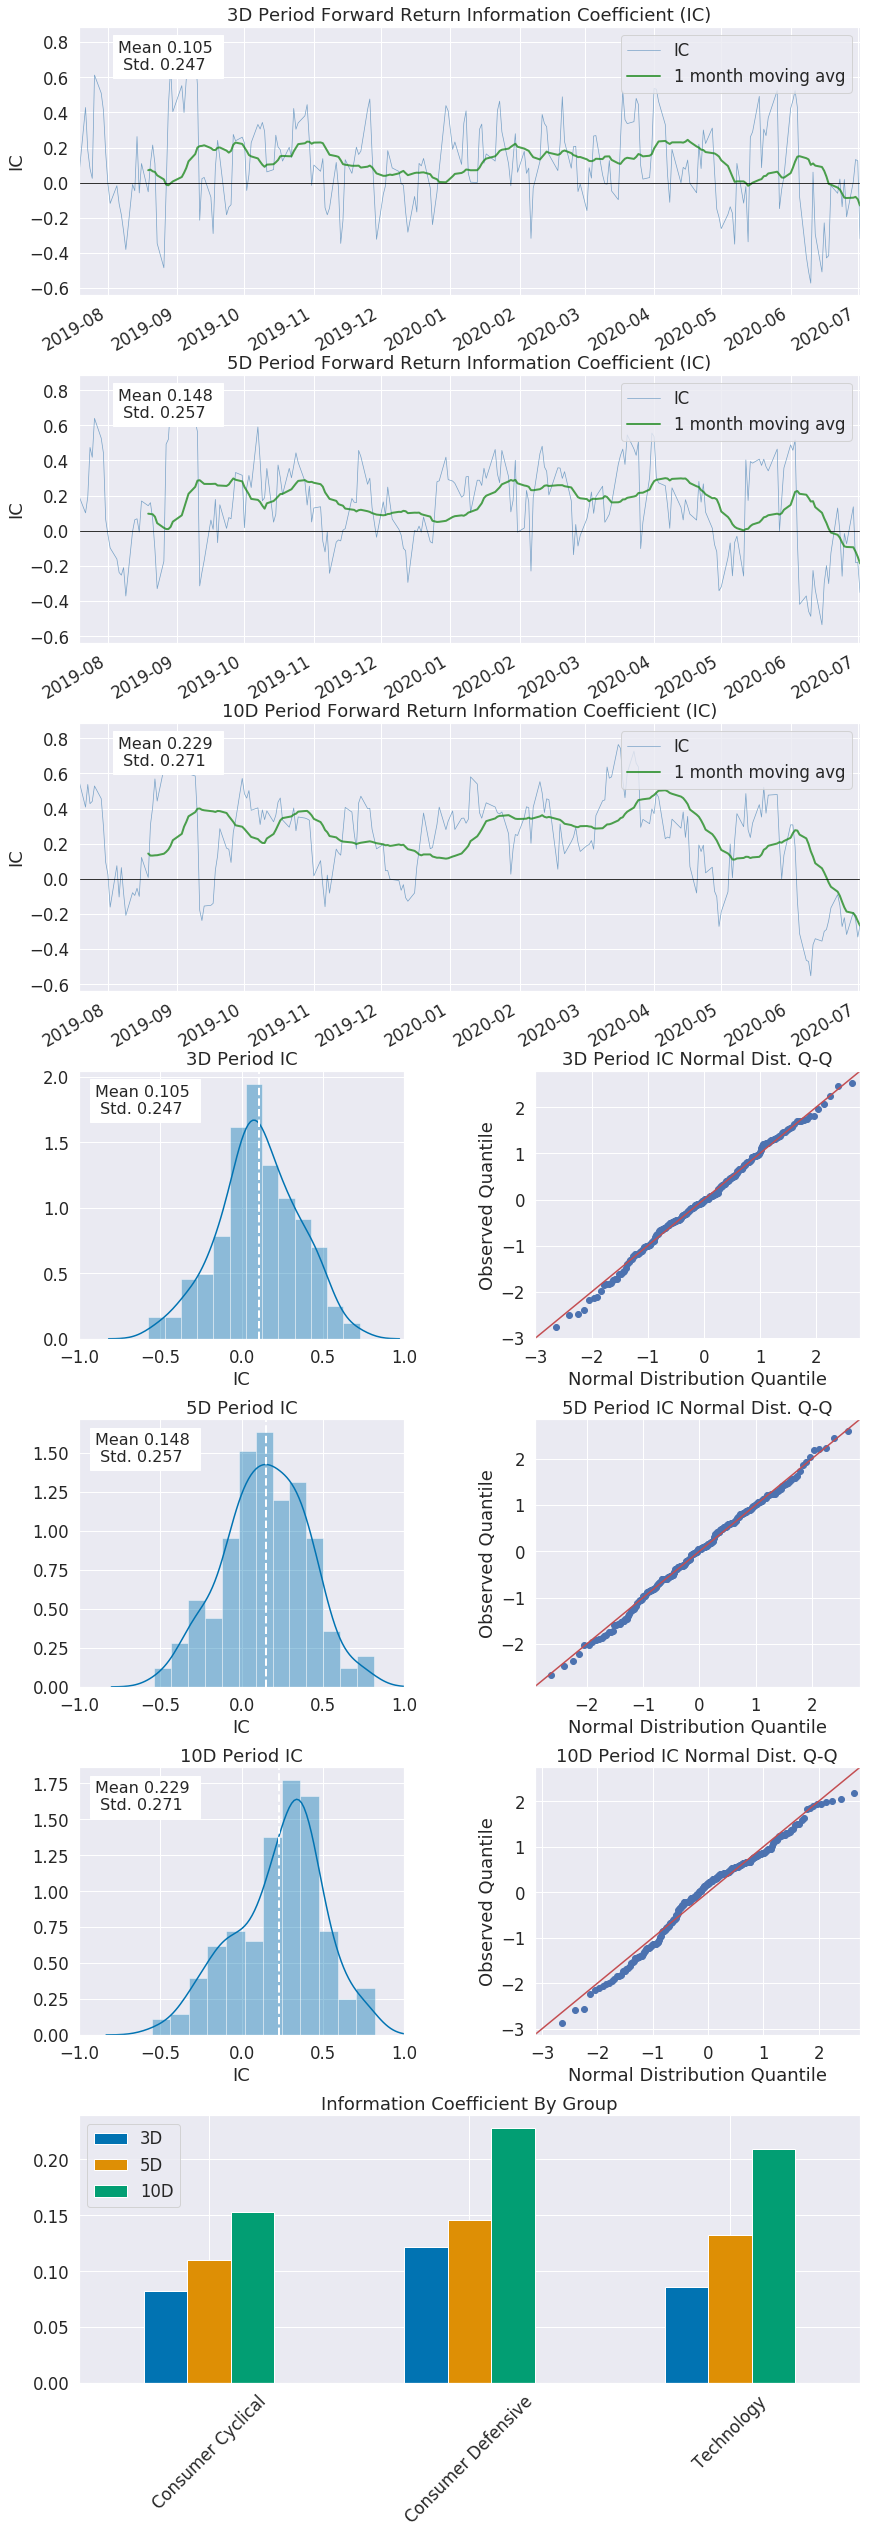

Turnover Analysis


10D     3D     5D
Quantile 1 Mean Turnover   0.466  0.226  0.319
Quantile 2 Mean Turnover   0.470  0.208  0.306

3D     5D    10D
Mean Factor Rank Autocorrelation  0.948  0.927  0.897

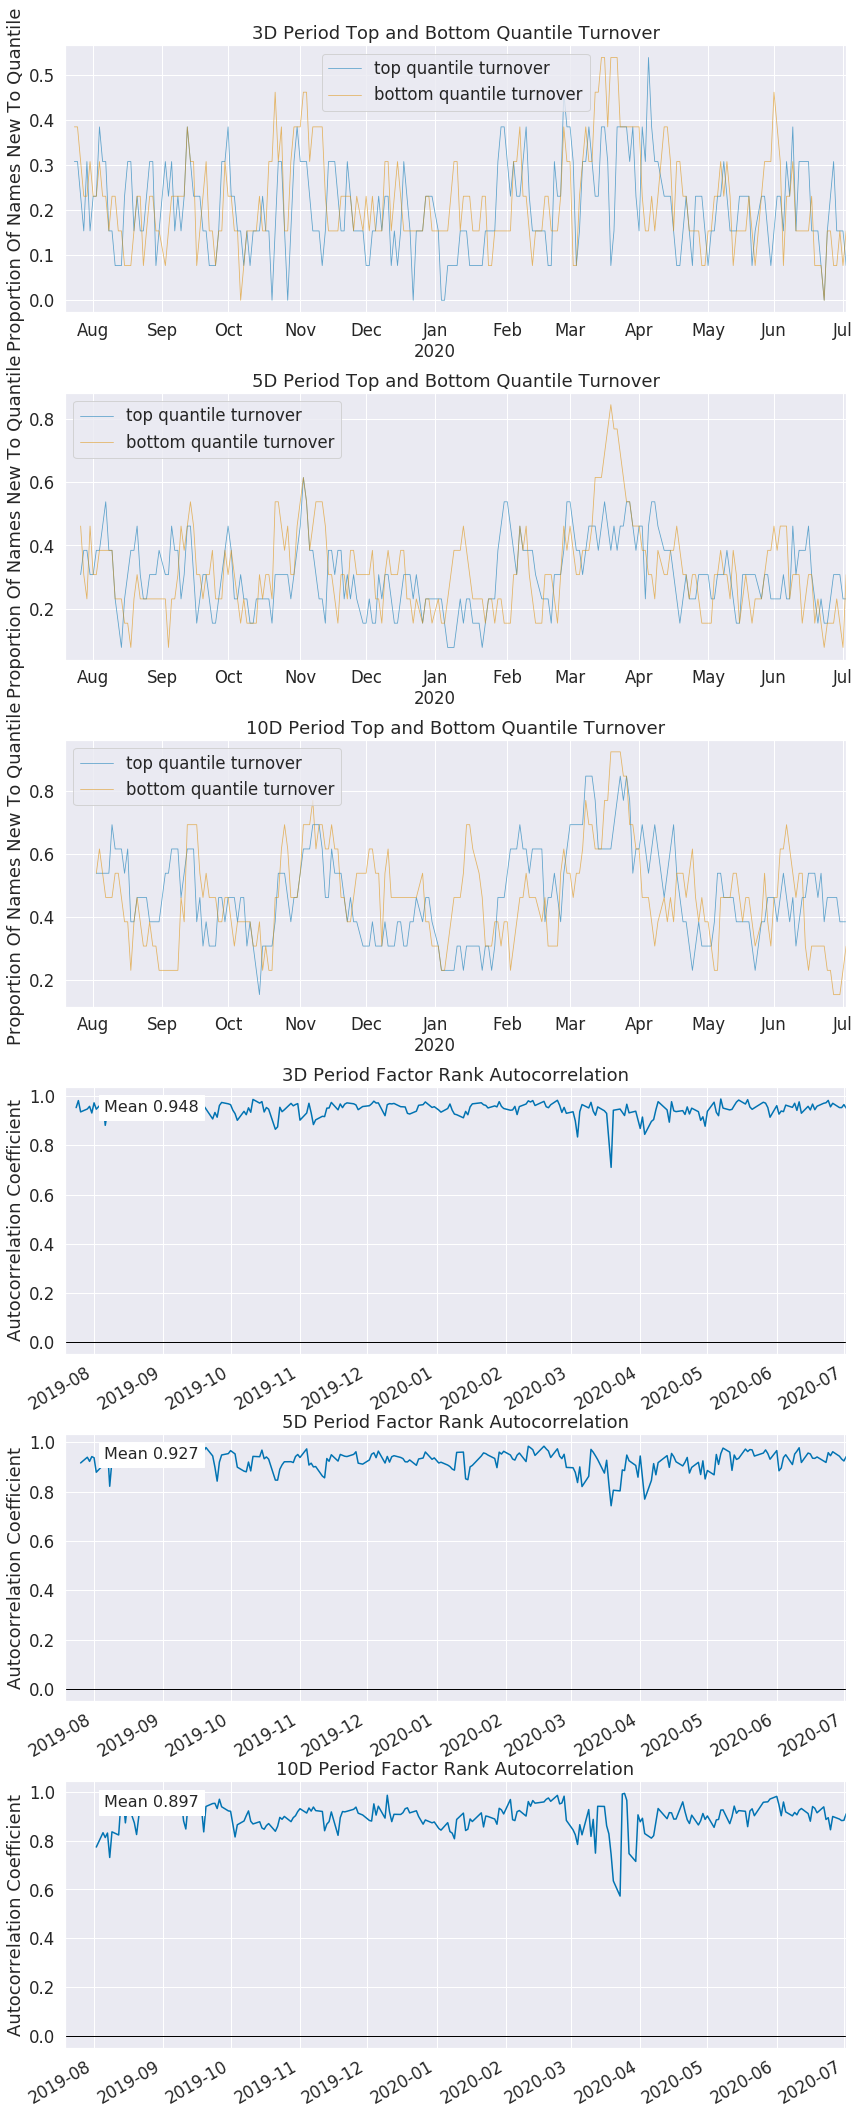

In [108]:
al.tears.create_full_tear_sheet(factor_data, by_group=True, long_short=True, group_neutral=False);

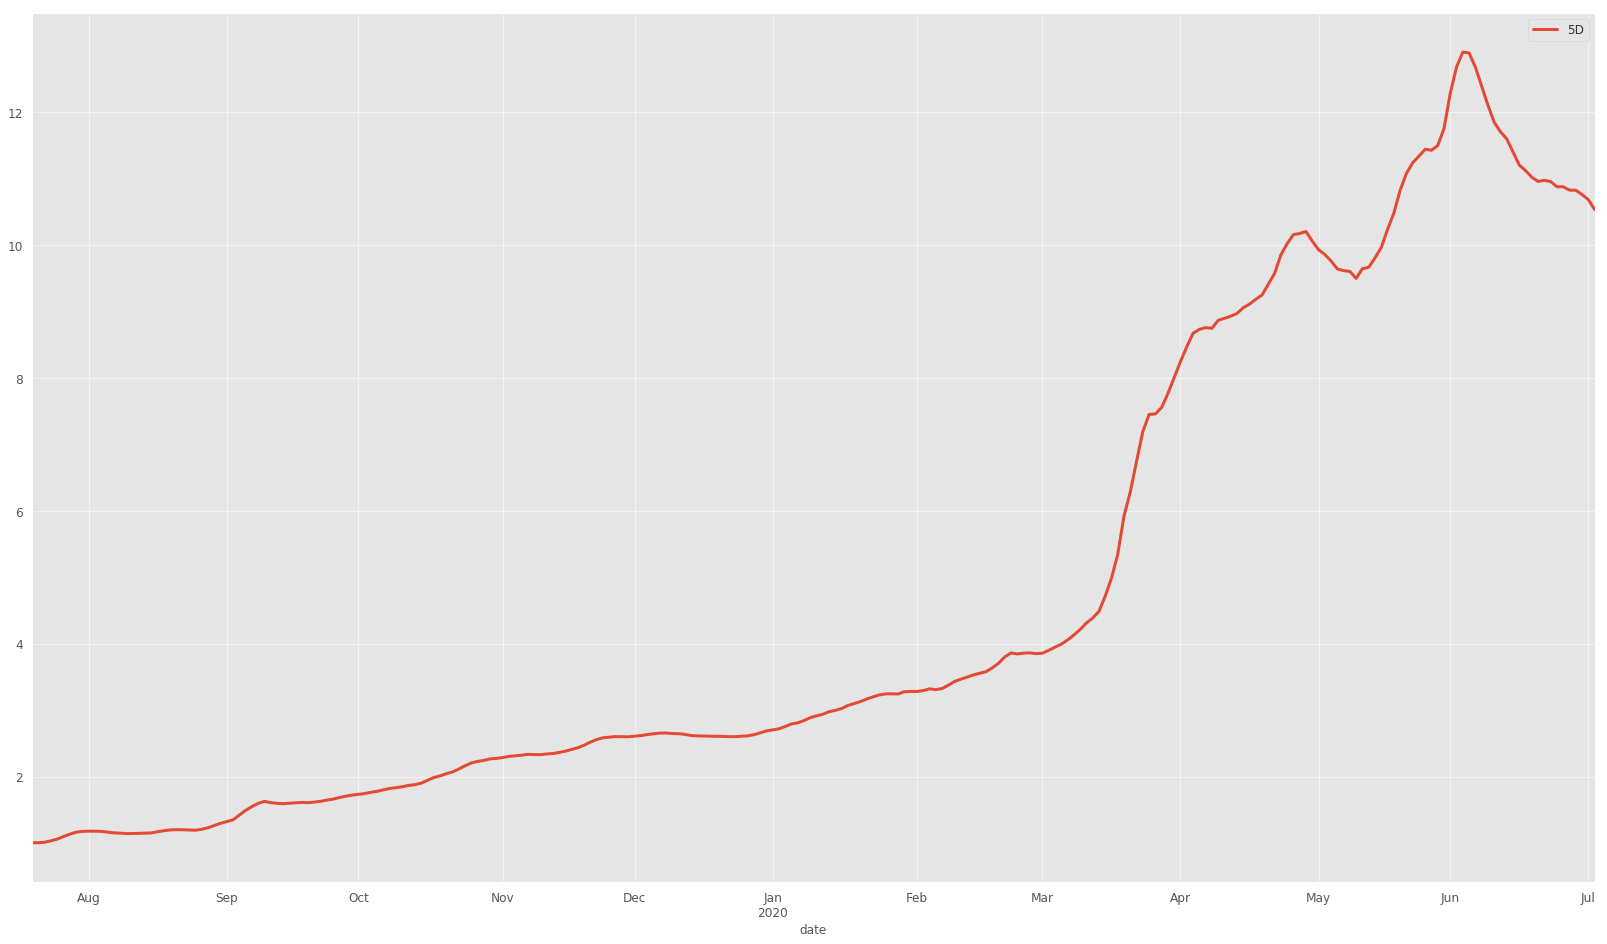

In [109]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (28, 16)

ls_factor_returns = al.performance.factor_returns(factor_data[['factor','5D']])

(1+ls_factor_returns).cumprod().plot(lw=3);

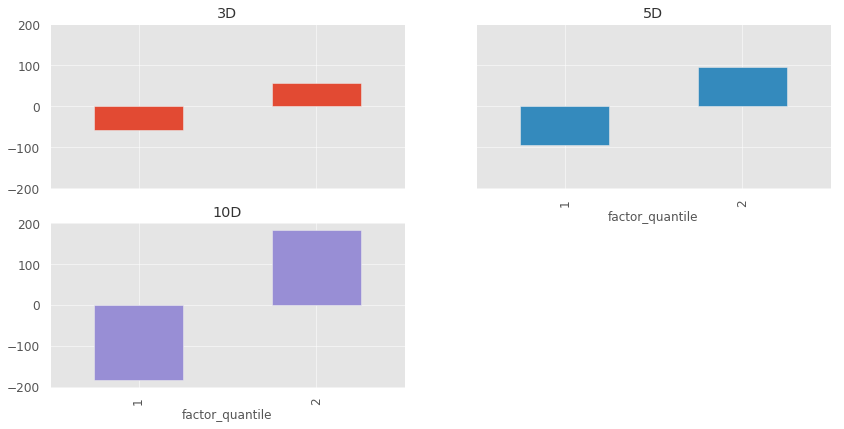

In [110]:
qr_factor_returns = pd.DataFrame()

qr_factor_returns = al.performance.mean_return_by_quantile(factor_data)[0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

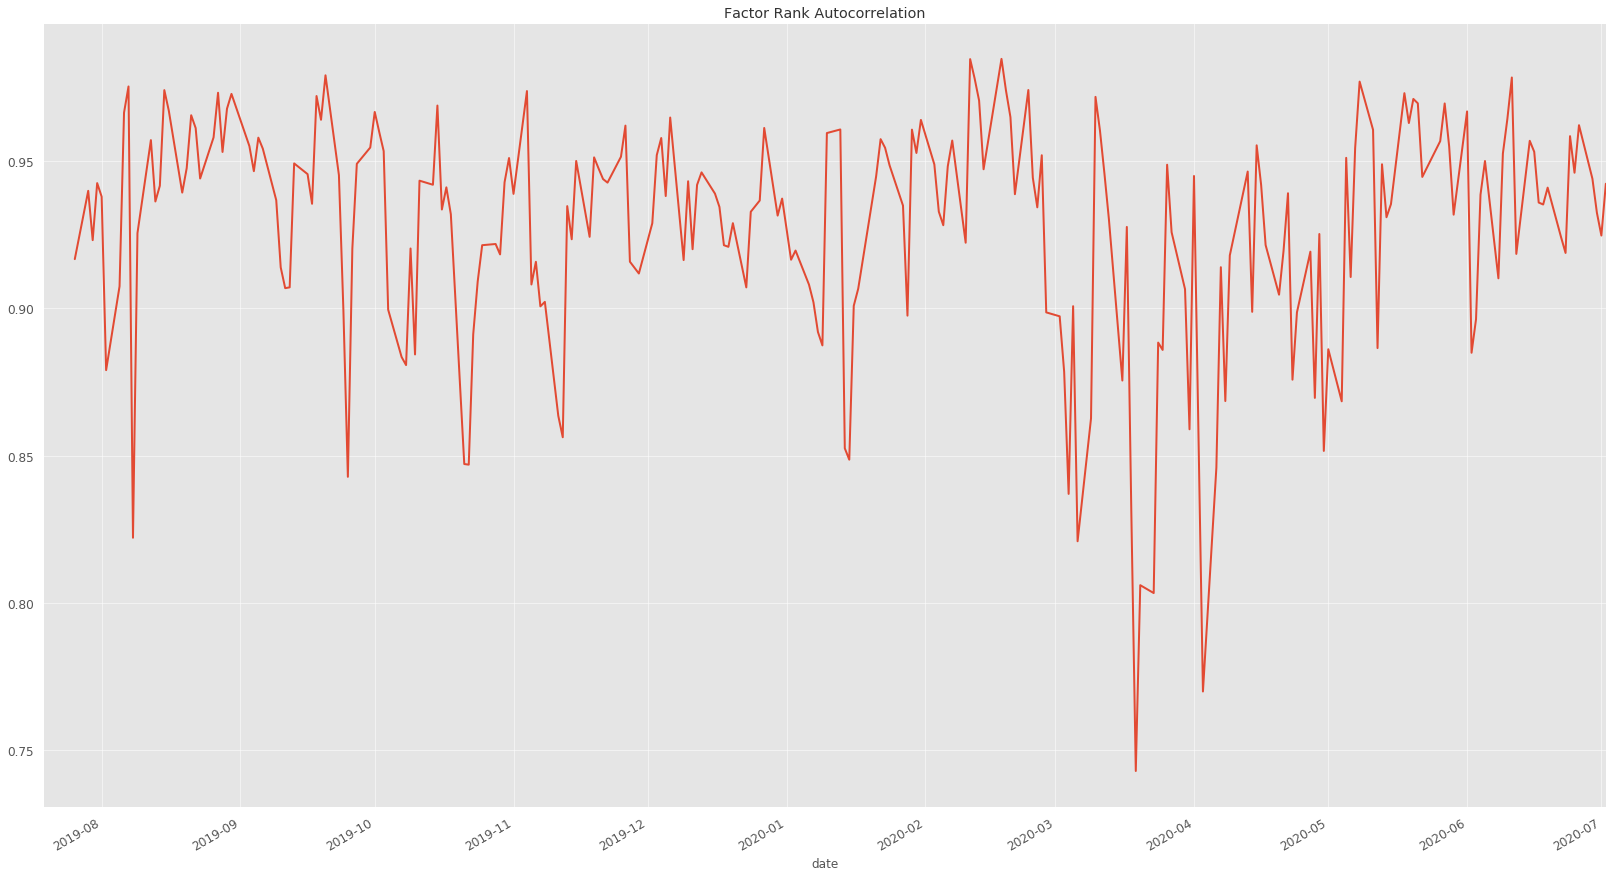

In [111]:
ls_FRA = pd.DataFrame()
ls_FRA = al.performance.factor_rank_autocorrelation(factor_data, period = rebalance_period)
ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

In [112]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

5D    9.63
dtype: float64

# 10 - Predicted Portfolio

In [113]:
optimal_weights_regularized = final_vector[['optimal_weights']].loc[final_vector.index.levels[0][-1]]

for 26 assets  with end date: 2020-07-17 00:00:00+00:00


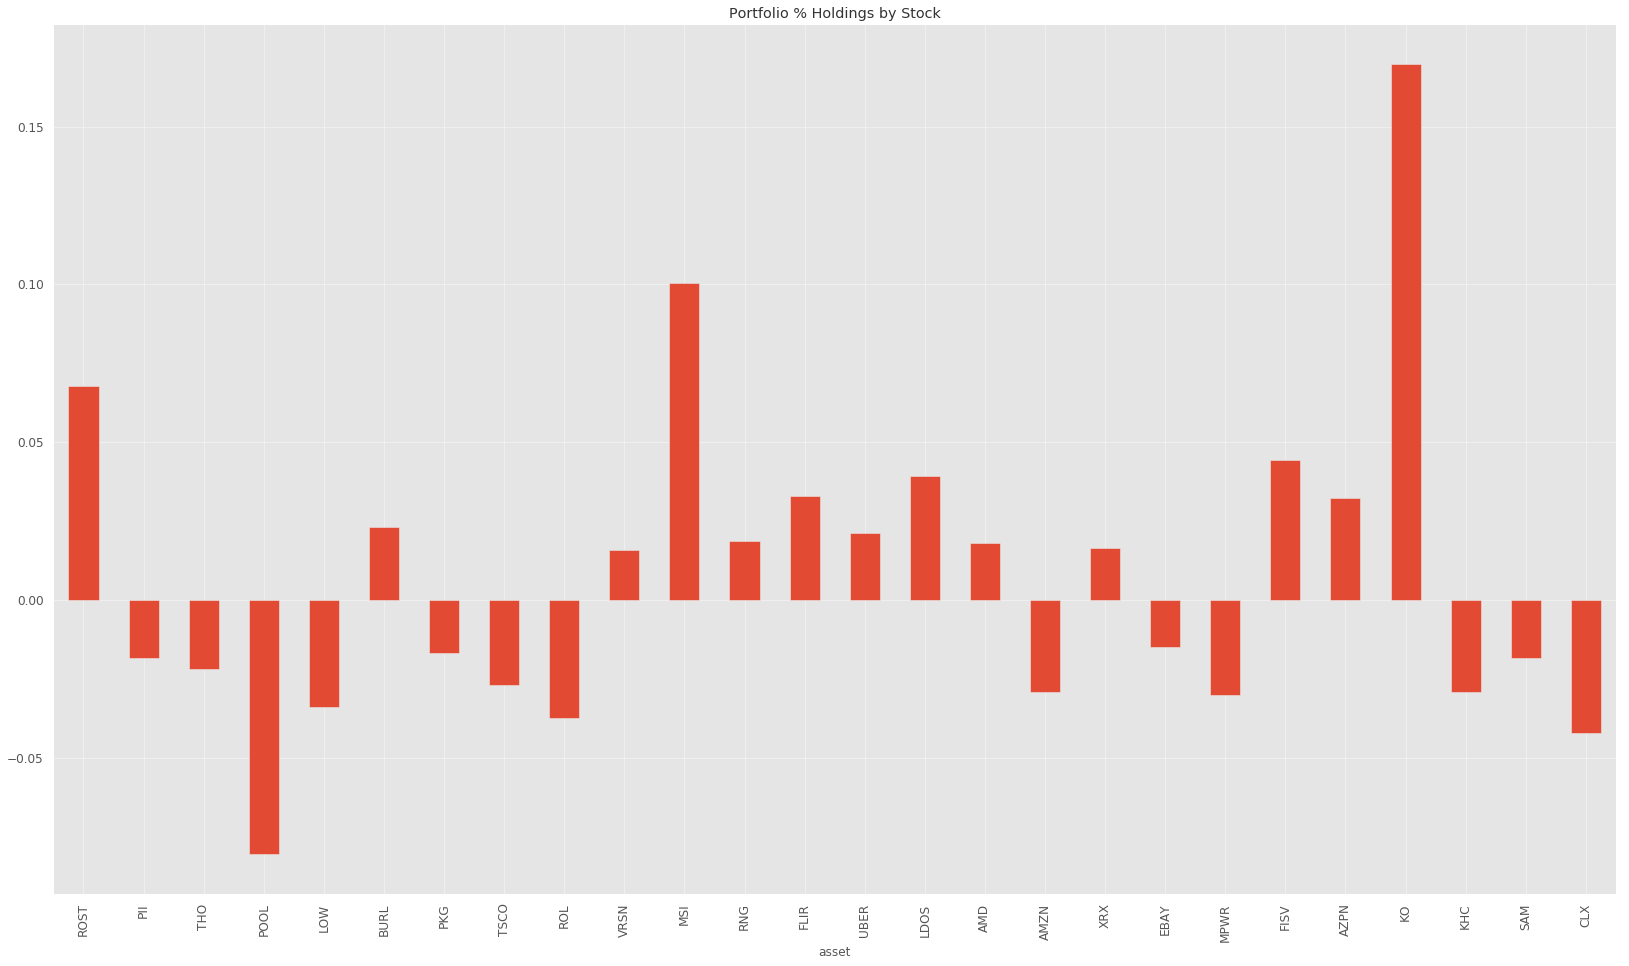

In [114]:
print ('for {} assets  with end date: {}'.format(len(optimal_weights_regularized.index),optimal.index[-1]))
optimal_weights_regularized.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
plt.grid(alpha=0.8)

In [115]:
optimal_weights_regularized = pd.DataFrame(data = optimal_weights_regularized.values, 
                                           columns = ['optimal_weights'],
                                           index = optimal_weights_regularized.index)
optimal_weights_regularized.index.name = 'asset'

In [116]:
q5 = optimal_weights_regularized.sort_values(by='optimal_weights',ascending=False)[:len(optimal_weights_regularized.index)//5]
q1 = optimal_weights_regularized.sort_values(by='optimal_weights',ascending=True)[:len(optimal_weights_regularized.index)//5]

In [117]:
print (q5.iloc[0])
print (q1.iloc[0])

optimal_weights    0.169929
Name: KO, dtype: float64
optimal_weights   -0.080635
Name: POOL, dtype: float64


## 10 - 3 - Risk analysis with optimized weights

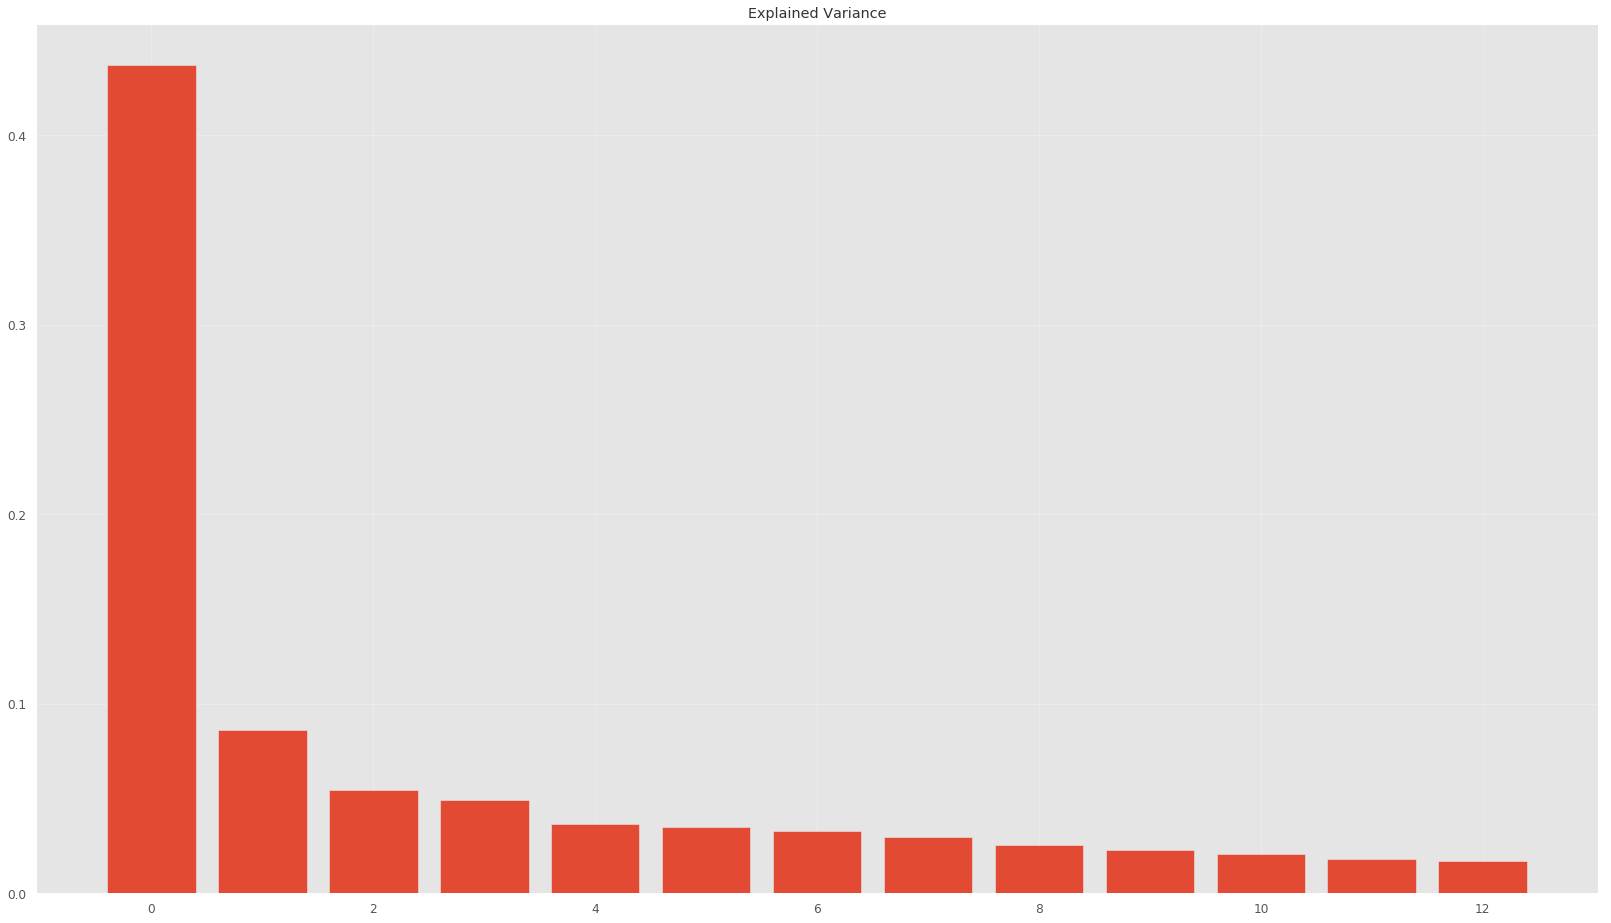

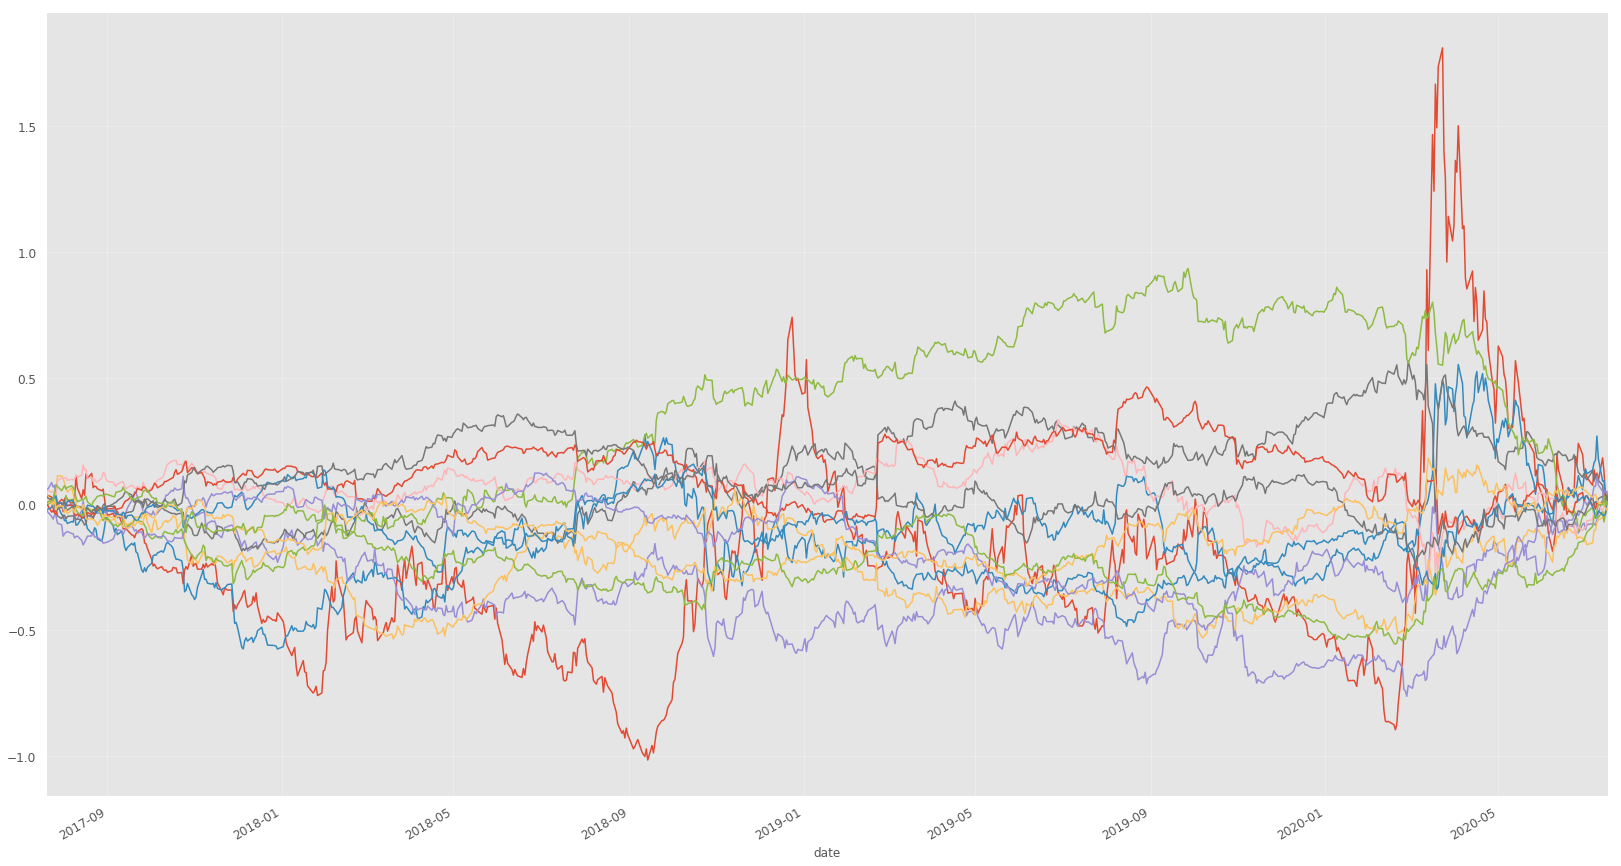

In [118]:
predicted_portfolio_risk,Risk_Model = risk_model.portfolio_risk(close[optimal_weights_regularized.index],num_factor_exposures=factor_exposures,weights=optimal_weights_regularized)

In [119]:
print ('Predicted Risk: {} %'.format(np.round((predicted_portfolio_risk*100),2)))

Predicted Risk: 8.26 %


In [120]:
all_factors.to_csv('data/all_factors.csv')
close.to_csv('data/close.csv')
optimal_weights_regularized.to_csv('output/optimal_weights_regularized.csv')

In [121]:
import vlc
p = vlc.MediaPlayer("/home/k13104/Desktop/ES_PREL Whoosh Soft 7 - SFX Producer.mp3")
p.play()

0

In [122]:
print ('leverage is {}'.format(optimal_weights_regularized.abs().sum().round(2)[0]))
print ('long/short leverage balance is {}'.format(optimal_weights_regularized.sum().round(2)[0]))

leverage is 1.0
long/short leverage balance is 0.2


In [123]:
assert optimal_weights_regularized.sum().round(2)[0] == np.round((percent_long_leverage_target - percent_short_leverage_target),1)
assert optimal_weights_regularized.abs().sum().round(2)[0] == 1.0